# PHYS20762 - Project - Simulating The Absorption, Scattering And Transmission Of Thermal Neutrons 

Jatin Sharma<br>
University of Manchester  
January 2021

# Introduction

In this report a simulation of penetration of neutrons through a slab of
shielding of thickness T will be developed, considering only thermal neutrons, and the processes of absorption and
scattering. A thermal neutron is any free neutron that moves relatively slowly with a low energy. They also have large fission cross sections which makes them useful in many applications. Therefore, gaining an understanding of how thermal neutrons interact with other materials is useful.

# The Monte Carlo Method

In this project thermal neutrons colliding with a material will be simulated. In order to simulate random processes the Monte Carlo method can be used. A Monte Carlo simulation is a model used to predict the probability of different outcomes when random variables are present. In this case the fraction of neutrons scattered, transmitted and absorbed can be calculated. 

For this method to work random numbers must be generated such that bias is not introduced into our investigation. It is important to note that we do not want to generate truly random numbers. We really want sequences that do not correlate with the process we are simulating.

We first initialise our Python interpreter

In [1]:
# Initialisation
import string
import cmath
from math import *
import math
import numpy as np
from numpy.linalg import inv
from numpy import zeros, linspace
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
%matplotlib notebook 
plt.rcParams.update({'font.size': 14})
plt.style.use('default')

In [2]:
# Constants 
barn_to_cm_conversion = 1 * 10**-24
density_water = 1 #g/cm^3
density_lead = 11.35 #g/cm^3
density_graphite = 1.67 #g/cm^3
cross_section_abs_water = 0.6652 #absorption cross section in barn
cross_section_abs_lead = 0.158 #absorption cross section in barn
cross_section_abs_graphite = 0.0045 #absorption cross section in barn
cross_section_scat_water = 103.0 #scattering cross section in barn
cross_section_scat_lead = 11.221 #scattering cross section in barn
cross_section_scat_graphite = 4.74 #scattering cross section in barn
N_A = 6.0221 * 10**23 #avogadro's constant in 1/mol
M_water = 18.0153 #molar mass in g/mol
M_lead = 207.2 #molar mass in g/mol
M_graphite = 12.01 #molar mass in g/mol
number_density_tot_water = (density_water * N_A) / M_water #total number denisty in cm^-3
number_density_tot_lead = (density_lead * N_A) / M_lead #total number denisty in cm^-3
number_density_tot_graphite = (density_graphite * N_A) / M_graphite #total number denisty in cm^-3

In [3]:
# Functions
def randssp(p, q):
    """
    This function uses the "bad" generator parameters that IBM used in several libraries in the 1960's. There is a strong 
    serial correlation between three consecutive values.

    Parameters
    ----------
    p : int
        sets the size of the array r
    q : int
        sets the size of the array r

    Returns
    -------
    r : numpy array
        array of randomly generated data points

    """
    
    global m, a, c, x
        
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a * x + c, m)
            r[k, l] = x / m
    return r

def data_cleaner_1(data_1, data_2):
    """
    This function combines two data sets where the second data set has one value too many. It then removes all rows
    containing a value of zero and returns a new cleaned data set.

    Parameters
    ----------
    data_1 : numpy array
    data_2 : numpy array

    Returns
    -------
    NR_cleaned : numpy array
    Ri_cleaned : numpy array

    """
    combined_data = np.transpose(np.vstack((data_1, data_2[:-1])))
    new_data = combined_data[~np.any(combined_data == 0, axis=1)]
    NR_cleaned = new_data[:, 0]
    Ri_cleaned = new_data[:, 1]
    return NR_cleaned, Ri_cleaned

def data_cleaner_2(data_1, data_2, data_3):
    """
    This function combines two data sets where both data sets have the same number of values. It then removes all rows
    containing a value of zero and returns a new cleaned data set.

    Parameters
    ----------
    data_1 : numpy array
    data_2 : numpy array

    Returns
    -------
    NR_cleaned : numpy array
    Ri_cleaned : numpy array

    """
    combined_data = np.transpose(np.vstack((data_1, data_2, data_3)))
    new_data = combined_data[~np.any(combined_data == 0, axis=1)]
    NR_cleaned = new_data[:, 0]
    Ri_cleaned = new_data[:, 1]
    error_cleaned = new_data[:, 2]
    return NR_cleaned, Ri_cleaned, error_cleaned

def fit_data_1(x_value, y_value):
    fit_parameters, fit_errors = np.polyfit(x_value, np.log(y_value), 1, cov=True)
    m = fit_parameters[0]
    c = fit_parameters[1]
    sigma_m = np.sqrt(fit_errors[0][0])
    mean_free_path_fitted = -1 / m
    mean_free_path_error = (1 / m**2) * sigma_m
    return mean_free_path_fitted, mean_free_path_error, m, c

def random_vector():
    """
    This function generates a random set of x, y and z values from spherical polar coordinates that are isotropic.
    
    Parameters
    ----------
    mean_free_path : float

    Returns
    -------
    vector : list
    
    """
    rand_i, rand_j = np.random.uniform(size=2) # two independent random numbers from a uniform distribution in the range (0, 1)
    phi = 2 * np.pi * rand_i # spherical coordinate theta
    theta = np.arccos(2 * rand_j - 1) # spherical coordinate phi, corrected for distribution bias
    x = np.cos(phi) * np.sin(theta) # cartesian coordinate x
    y = np.sin(theta) * np.sin(phi) # cartesian coordinate y
    z = np.cos(theta) # cartesian coordinate z
    vector = [x, y, z]
    return vector

def combination_of_vectors(data_points):
    """
    This function generates random x, y and z values based of the random_vector function and combines them in one
    data set.

    Parameters
    ----------
    data_points : int
        number of points to be plotted

    Returns
    -------
    vectors : numpy array
        an array containing all the vector values
    """
    count = 0
    #create empty arrays to be filled
    x_vectors = []
    y_vectors = []
    z_vectors = []
    #create many random points
    while count <= data_points - 1:
        count += 1
        vector = random_vector()
        x = vector[0]
        y = vector[1]
        z = vector[2]
        x_vectors = np.append(x_vectors, x)
        y_vectors = np.append(y_vectors, y)
        z_vectors = np.append(z_vectors, z)
    vectors = np.transpose(np.vstack((x_vectors, y_vectors, z_vectors)))
    return vectors

def total_mean_free_path_calculator(cross_section_scat, cross_section_abs, number_density):
    """
    This function finds the total mean free path for a given material.

    Parameters
    ----------
    cross_section_scat : float
    cross_section_abs : float
    number_density : float

    Returns
    -------
    mean_free_path_total : float
    macroscopic_cross_section_abs : float
    macroscopic_cross_section_tot : float

    """
    mean_free_path_abs = 1 / (number_density * cross_section_abs * barn_to_cm_conversion)
    mean_free_path_scat = 1 / (number_density * cross_section_scat * barn_to_cm_conversion)
    macroscopic_cross_section_abs = 1 / mean_free_path_abs
    macroscopic_cross_section_scat = 1 / mean_free_path_scat
    macroscopic_cross_section_tot = macroscopic_cross_section_abs + macroscopic_cross_section_scat
    mean_free_path_total = 1 / (macroscopic_cross_section_tot) 
    return mean_free_path_total, macroscopic_cross_section_abs, macroscopic_cross_section_tot

def random_step(mean_free_path):
    """
    This function generates one step based on an exponential distribuition.

    Parameters
    ----------
    mean_free_path : float

    Returns
    -------
    -mean_free_path * np.log(u) : float
        a random step
    
    """
    u = 1.0 - np.random.uniform() #avoids log(0)
    return -mean_free_path * np.log(u)

def scattering_absorption_simulation(total_mean_free_path, macroscopic_cross_section_abs, macroscopic_cross_section_tot,\
                                     nparticles, T):
    """
    This function simulates particles approaching a slab where absorption and scattering can take place. 

    Parameters
    ----------
    total_mean_free_path : float
    macroscopic_cross_section_abs : float
    macroscopic_cross_section_tot : float
    nparticles : int
    T : float
        thickness of material

    Returns
    -------
    trajectories : dictionairy
        contains all the trajectories of each particle
    """
    trajectories = {} #dictionary for all trajectories
    
    for k in range(0, nparticles):
        trajectory = []
        #initialize particle position
        x = 0.0
        y = 0.0
        z = 0.0
        trajectory.append((x, y, z))
        count = 0
        while True:
            if count==0:
                #for the first step we want the particle to move along the x axis
                wx = 1
                wy = 0
                wz = 0
                #create a random step
                step = random_step(total_mean_free_path)
                #find new position
                x += wx * step
                y += wy * step
                z += wz * step
                #add these new positions to trajectory
                trajectory.append((x, y, z))
                #see if the neutron has left the slab
                if x > T:
                    trajectories[k] = trajectory
                    count += 1
                    break #neutron has left, end of trajectory, next particle would be tracked
                else:
                    count += 1
                    pass
                    #simulate absorbtion
                    if np.random.uniform() < (macroscopic_cross_section_abs) / (macroscopic_cross_section_tot):
                        trajectories[k] = trajectory
                        count += 1
                        break #absorbtion, end of trajectory, next particle would be tracked
                    else:
                        count += 1
                        pass #scattering, continue with this trajectory
            else:
                #generate random isotropic unit vectors
                initial_vector = random_vector()
                wx = initial_vector[0]
                wy = initial_vector[1]
                wz = initial_vector[2]
                #create a random step
                step = random_step(total_mean_free_path)
                #find new position
                x += wx * step
                y += wy * step
                z += wz * step
                #add these new positions to trajectory
                trajectory.append((x, y, z))
                #see if the neutron has left the slab
                if x > T or x < 0:
                    trajectories[k] = trajectory
                    count += 1
                    break #neutron has left, end of trajectory, next particle would be tracked
                else:
                    count += 1
                    pass
                    #simulate absorbtion
                    if np.random.uniform() < (macroscopic_cross_section_abs) / (macroscopic_cross_section_tot):
                        trajectories[k] = trajectory
                        count += 1
                        break #absorbtion, end of trajectory, next particle would be tracked
                    else:
                        count += 1
                        pass #scattering, continue with this trajectory
    return trajectories

def plot_random_walk(trajectories, particle_number, material):
    """
    This function plots the random walk of a specified particle. 

    Parameters
    ----------
    trajectories : dictionairy
        contains the trajectories for all particles in a given material
    particle_number : int
        the number of the particle whose random walk will be plotted

    Returns
    -------
    plt.show()
    """
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection='3d')

    #Data for a three-dimensional line
    k = particle_number - 1 #must have -1 as k starts from 0   

    trj = trajectories[k]

    xline = [x for x, y, z in trj]
    yline = [y for x, y, z in trj]
    zline = [z for x, y, z in trj]

    #plot trajectory
    ax.plot3D(xline, yline, zline, 'gray')

    #plot vertices
    xpts = [x for x, y, z in trj]
    ypts = [y for x, y, z in trj]
    zpts = [z for x, y, z in trj]
    rpts = [np.sqrt(x * x + y * y + z * z) for x, y, z in trj]

    plot = ax.scatter3D(xpts, ypts, zpts, c=rpts, cmap='hsv')
    cbar=plt.colorbar(plot)
    cbar.set_label("x value (cm)")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Random walk plot for ' + material + ' and particle number ' + str(particle_number))

    return plt.show()

def final_particle_state(trajectories, T):
    """
    This function calculates how many thermal neutrons are absorbed, reflected and transmitted in a given material.

    Parameters
    ----------
    trajectories : dictionairy
        contains the trajectories for all particles in a given material
    T : float
        the thicknes of material
    
    Returns
    -------
    number_transmitted : int
    number_reflected : int
    number_absorbed : int
    """
    #create an empty array to be filled by the final position of the particle
    final_number_array = []
    #loop through each particle in the system
    for particle_number in trajectories:
        #find all the position vectors for a single particle
        numbers_list = trajectories[particle_number]
        #get the final position vector of the particle
        final_list = numbers_list[-1]
        #get the x position vector for the particle
        final_number = final_list[0]
        #create an array for the final x position vectors for all particles in the system
        final_number_array = np.append(final_number_array, final_number)
    #count all the transmitted, relflected and absorbed neutrons
    number_transmitted = 0
    number_reflected = 0
    number_absorbed = 0
    for x_value in final_number_array:
        if x_value > T:
            number_transmitted += 1
        elif x_value < 0:
            number_reflected += 1
        else:
            number_absorbed += 1
    return number_transmitted, number_reflected, number_absorbed

def multiple_trials(mean_free_path_total, macroscopic_cross_section_abs
                    ,macroscopic_cross_section_tot, number_of_particles, T, trial_number):
    """
    This function runs the simulation for a given material by a specified amount of times and calculates the mean number
    of particles absorbed, reflected and transmitted.

    Parameters
    ----------
    mean_free_path_total : float
    macroscopic_cross_section_abs : float
    macroscopic_cross_section_tot : float
    number_of_particles : int
    T : float 
        thickness of material
    trial_number : int
        number of times the simulation is run for
    
    Returns
    -------
    transmitted_mean : float
    reflected_mean : float
    absorbed_mean : float
    transmitted_stdev : float
    reflected_stdev : float
    absorbed_stdev : float
    """
    count = 0
    transmitted_array = []
    reflected_array = []
    absorbed_array = []
    while count <= trial_number - 1:
        #find the trajectories for all particles in each material
        trajectories_material = scattering_absorption_simulation(mean_free_path_total, macroscopic_cross_section_abs\
                                                              ,macroscopic_cross_section_tot, number_of_particles, T)
        #find the number of neutrons transmitted, reflected and absorbed
        number_transmitted, number_reflected, number_absorbed = final_particle_state(trajectories_material, T)
        transmitted_array = np.append(transmitted_array,  number_transmitted)
        reflected_array = np.append(reflected_array,  number_reflected)
        absorbed_array = np.append(absorbed_array,  number_absorbed)
        count += 1
    transmitted_mean = np.mean(transmitted_array)
    reflected_mean = np.mean(reflected_array)
    absorbed_mean = np.mean(absorbed_array)
    transmitted_stdev = np.std(transmitted_array)
    reflected_stdev = np.std(reflected_array)
    absorbed_stdev = np.std(absorbed_array)
    
    return transmitted_mean, reflected_mean, absorbed_mean, transmitted_stdev, reflected_stdev, absorbed_stdev

def percent_error_calculator(transmitted_error, absorbed_error, reflected_error):
    """
    This function calculates the percentage error on the transmitted, absorbed and relflected neutrons.

    Parameters
    ----------
    transmitted_error : float
        absolute transmiited neutron error
    absorbed_error : float
        absolute absorbed neutron error
    reflected_error : float
        absolute reflected neutron error
    
    Returns
    -------
    transmitted_percent_error : float
    absorbed_percent_error : float
    reflected_percent_error : float
    """
    transmitted_percent_error = (transmitted_error / number_of_particles) * 100
    absorbed_percent_error = (absorbed_error / number_of_particles) * 100
    reflected_percent_error = (reflected_error / number_of_particles) * 100
    return transmitted_percent_error, absorbed_percent_error, reflected_percent_error


def error_changing_particle_number_calculator(mean_free_path_total, macroscopic_cross_section_abs, 
                                              macroscopic_cross_section_tot, number_of_particles_range, T, 
                                              trial_number):
    """
    This function runs the simulation for different total particle numbers and calculates the error on the number of neutrons
    transmitted, absorbed and reflected at each particle number.

    Parameters
    ----------
    mean_free_path_total : float
    macroscopic_cross_section_abs : float
    macroscopic_cross_section_tot : float
    number_of_particles : int
    T : float 
    thickness of material
    trial_number : int
        number of times the simulation is run for
        
    Returns
    -------
    transmitted_fractional_stdev_array : numpy array
        an array containing all the errors found at each particle number for transmitted neutrons 
    reflected_fractional_stdev_array : numpy array
        an array containing all the errors found at each particle number for reflected neutrons 
    absorbed_fractional_stdev_array : numpy array
        an array containing all the errors found at each particle number for absorbed neutrons 
    """
    transmitted_fractional_stdev_array = []
    reflected_fractional_stdev_array = []
    absorbed_fractional_stdev_array = []
    for particle in number_of_particles_range:
        #find the errors on particles that are transmitted, absorbed and reflected
        transmitted_mean, reflected_mean, absorbed_mean, transmitted_stdev, reflected_stdev, absorbed_stdev = \
                                                                                    multiple_trials(mean_free_path_total, 
                                                                                    macroscopic_cross_section_abs, \
                                                           macroscopic_cross_section_tot, particle, T, trial_number)
        #find the fractional errors
        transmitted_fractional_stdev =  transmitted_stdev / transmitted_mean
        reflected_fractional_stdev =  reflected_stdev / reflected_mean
        absorbed_fractional_stdev =  absorbed_stdev / absorbed_mean
        #append these results to an array
        transmitted_fractional_stdev_array = np.append(transmitted_fractional_stdev_array, transmitted_fractional_stdev)
        reflected_fractional_stdev_array = np.append(reflected_fractional_stdev_array, reflected_fractional_stdev)
        absorbed_fractional_stdev_array = np.append(absorbed_fractional_stdev_array, absorbed_fractional_stdev)
    return transmitted_fractional_stdev_array, reflected_fractional_stdev_array, absorbed_fractional_stdev_array

def vary_thickness(thickness, mean_free_path_total, macroscopic_cross_section_abs, macroscopic_cross_section_tot,\
                   number_of_particles, trial_number):
    """
    This function runs the simulation for different material thicknesses and calculates the number of particles transmited, 
    reflected and absorbed at each thickness. 

    Parameters
    ----------
    thickness : numpy array
        array of all the thickness values to be used
    mean_free_path_total : float
    macroscopic_cross_section_abs : float
        macroscopic cross section for absorption
    macroscopic_cross_section_tot : float
        total macroscopic cross section
    number_of_particles : int
    trial_number : int
        the number of times the simulation should run
    
    Returns
    -------
    array_transmitted : numpy array
        an array containing all the numbers of neutrons transmitted at each thickness value
    array_absorbed : numpy array 
        an array containing all the numbers of neutrons absorbed at each thickness value
    array_reflected : numpy array
        an array containing all the numbers of neutrons reflected at each thickness value
    array_transmitted_stdev
        an array containing all the numbers of neutrons transmitted errors at each thickness value
    array_absorbed_stdev
        an array containing all the numbers of neutrons absorbed errors at each thickness value
    array_reflected_stdev
        an array containing all the numbers of neutrons reflected errors at each thickness value
        
    """
    #create arrays for all the final states of the particles
    array_transmitted = []
    array_absorbed = []
    array_reflected = []
    array_transmitted_stdev = []
    array_absorbed_stdev = []
    array_reflected_stdev = []
    for T in thickness:
        #find the number of neutrons transmitted, reflected and absorbed and their errors
        transmitted_mean, reflected_mean, absorbed_mean, transmitted_stdev, reflected_stdev,absorbed_stdev\
        = multiple_trials(mean_free_path_total, macroscopic_cross_section_abs, macroscopic_cross_section_tot,
                          number_of_particles, T, trial_number)
       
        #number_transmitted, number_reflected, number_absorbed = final_particle_state(trajectories, T)
        #append the final states of each particle to the array
        array_transmitted = np.append(array_transmitted, transmitted_mean)
        array_transmitted_stdev = np.append(array_transmitted_stdev, transmitted_stdev)
        array_absorbed = np.append(array_absorbed, absorbed_mean)
        array_absorbed_stdev =  np.append(array_absorbed_stdev, absorbed_stdev)
        array_reflected = np.append(array_reflected, reflected_mean)
        array_reflected_stdev = np.append(array_reflected_stdev, reflected_stdev)
    return array_transmitted, array_absorbed, array_reflected, array_transmitted_stdev, array_absorbed_stdev,\
            array_reflected_stdev

def plot_subplots(material, thickness, array_transmitted, array_transmitted_stdev, array_absorbed, array_absorbed_stdev,
                 array_reflected, array_reflected_stdev):
    """
    This function plots a figure for number of neutrons transmitted, absorbed and scattered against slab thickneess, along
    with their associated errors.

    Parameters
    ----------
    material : string
        name of material to be plotted
    thickness : numpy array
        array of all the thickness values to be used
    array_transmitted : numpy array
        an array containing all the numbers of transmitted neutrons to be plotted
    array_transmitted_stdev : numpy array
        an array containing all the numbers of transmitted neutrons to be plotted
    array_absorbed : numpy array
        an array containing all the numbers of absorbed neutrons to be plotted
    array_absorbed_stdev : numpy array
        an array containing all the numbers of absorbed neutrons to be plotted
    array_reflected : numpy array
        an array containing all the numbers of reflected neutrons to be plotted
    array_reflected_stdev : numpy array
        an array containing all the numbers of reflected neutrons to be plotted
    
    Returns
    -------
    plt.show()
    """
    fig_2, axs_2 = plt.subplots(3, 1, figsize=(7, 9), tight_layout=True)
    axs_2[0].errorbar(thickness, array_transmitted, yerr=array_transmitted_stdev, ecolor='black', capsize=1,
                      elinewidth=0.7)
    axs_2[0].set_title('Variation in neutrons transmitted with slab thickness -' + material)
    axs_2[0].set_xlabel('Slab thickness, $T$ (cm)')
    axs_2[0].set_ylabel('Number of neutrons transmitted')
    axs_2[1].errorbar(thickness, array_absorbed, yerr=array_absorbed_stdev, ecolor='black', capsize=1,
                      elinewidth=0.7)
    axs_2[1].set_title('Variation in neutrons absorbed with slab thickness -' + material)
    axs_2[1].set_xlabel('Slab thickness, $T$ (cm)')
    axs_2[1].set_ylabel('Number of neutrons absorbed')
    axs_2[2].errorbar(thickness, array_reflected, yerr=array_reflected_stdev, ecolor='black', capsize=1,
                      elinewidth=0.7)
    axs_2[2].set_title('Variation in neutrons reflected with slab thickness -' + material)
    axs_2[2].set_xlabel('Slab thickness, $T$ (cm)')
    axs_2[2].set_ylabel('Number of neutrons reflected')
    plt.plot()
    return plt.show()

def fit_data_2(fit, thickness, array_of_neutrons):
    """
    This function fits data according to a log or a decreasing exponential function.

    Parameters
    ----------
    fit : string
        the name of the fit, i.e 'log' or 'decreasing exponential'
    thickness : numpy array
        array of all the thicknesses
    array_of_neutrons : numpy array
        the array of neutrons transmitted, absorbed or reflected
    
    Returns
    -------
    m : float
        gradient of the fit
    sigma_m : float
        error on the gradient of the fit
    c : float
        y intercept of the fit
    sigma_c : float
        error on the y intercept of the fit
    """
    if fit == 'linear':
        fit_parameters, fit_errors = np.polyfit(thickness, array_of_neutrons, 1, cov=True)
        array_of_neutrons_fit = np.polyval(fit_parameters, thickness)
        fit_m = fit_parameters[0]
        fit_c = fit_parameters[1]
        sigma_m = np.sqrt(fit_errors[0][0])
        sigma_c = np.sqrt(fit_errors[1][1])
        # Expected error on data from the assumed fit
        sigma_array_of_neutrons_fit = np.sqrt(np.sum(np.power((array_of_neutrons)
                                                                - array_of_neutrons_fit, 2)) / 
                                                (len(array_of_neutrons) - 2))
    if fit == 'exponential decrease':
        fit_parameters, fit_errors = np.polyfit(np.exp(-thickness), array_of_neutrons, 1, cov=True)
        array_of_neutrons_fit = np.polyval(fit_parameters, np.exp(-thickness))
        fit_m = fit_parameters[0]
        fit_c = fit_parameters[1]
        sigma_m = np.sqrt(fit_errors[0][0])
        sigma_c = np.sqrt(fit_errors[1][1])
        # Expected error on data from the assumed fit
        sigma_array_of_neutrons_fit = np.sqrt(np.sum(np.power((array_of_neutrons)
                                                                - array_of_neutrons_fit, 2)) / 
                                                (len(array_of_neutrons) - 2))
    if fit == 'log':
        fit_parameters, fit_errors = np.polyfit(np.log(thickness), array_of_neutrons, 1, cov=True)
        fit_m = fit_parameters[0]
        fit_c = fit_parameters[1]
        sigma_m = np.sqrt(fit_errors[0][0])
        sigma_c = np.sqrt(fit_errors[1][1])
    return fit_m, fit_c, sigma_m, sigma_c

def print_equation(material, fit, m, sigma_m, c, sigma_c):
    """
    This function prints the equation of a log or decreasing exponential function.

    Parameters
    ----------
    fit : string
        the name of the fit, i.e 'log' or 'decreasing exponential'
    m : float
        gradient of the fit
    sigma_m : float
        error on the gradient of the fit
    c : float
        y intercept of the fit
    sigma_c : float
        error on the y intercept of the fit
    
    Returns
    -------
    None
    """
    
    if fit == 'transmitted':
        print(('The equation describing the number of neutrons transmitted is: N_t =''({0:.1f} +/- {1:.2f})'' * exp(-T) + '
           '({2:.1f} +/- {3:.2f})').format(m, sigma_m, c, sigma_c))
      
    if fit == 'absorbed' and material == 'water':
        print(('The equation describing the number of neutrons absorbed is: N_t =''({0:.1f} +/- {1:.2f})'' * ln(T) + '
           '({2:.1f} +/- {3:.2f})').format(m, sigma_m, c, sigma_c))
        
    if (fit == 'absorbed' and (material == 'lead' or material == 'graphite')):
        print(('The equation describing the number of neutrons absorbed is: N_t =''({0:.1f} +/- {1:.2f})'' * T + '
           '({2:.1f} +/- {3:.2f})').format(m, sigma_m, c, sigma_c))

    if fit == 'reflected':
        print(('The equation describing the number of neutrons absorbed is: N_t =''({0:.1f} +/- {1:.2f})'' * ln(T) + '
           '({2:.1f} +/- {3:.2f})').format(m, sigma_m, c, sigma_c))
    return None

def scattering_absorption_woodcock_simulation(majorant_mean_free_path, macroscopic_cross_section_abs_1, 
                                              macroscopic_cross_section_tot_1, macroscopic_cross_section_abs_2, 
                                              macroscopic_cross_section_tot_2, nparticles, material_1_T, material_2_T):
    """
    This function runs a simulation of neutrons being absorbed, scattered or transmitted when moving through 2 materials. 
    The Woodcock method is used to implement this.
    
    Parameters
    ----------
    majorant_mean_free_path : float
        the minimum mean free path out of the two materials
    macroscopic_cross_section_abs_1 : float
        macroscopic cross section of absorption for material 1 
    macroscopic_cross_section_tot_1 : float
        total macroscopic cross section for material 1 
    macroscopic_cross_section_abs_2 : float
        macroscopic cross section of absorption for material 2
    macroscopic_cross_section_tot_2 : float
        total macroscopic cross section for material 2
    nparticles : int
        number of particles you want to simulate
    material_1_T : float
        the thickness of material 1
    material_2_T : float
        the thickness of material 2
        
    Returns
    -------
    trajectories : dictionairy
        a dictionairy containing all the particles trajectories

    """
    trajectories = {} #dictionary for all trajectories
    
    for k in range(0, nparticles):
        trajectory = []
        #initialize particle position
        x = 0.0
        y = 0.0
        z = 0.0
        trajectory.append((x, y, z))
        count = 0
        while True:
            if count==0:
                #for the first step we want the particle to move along the x axis
                wx = 1
                wy = 0
                wz = 0
                #create a random step
                step = random_step(majorant_mean_free_path) 
                if macroscopic_cross_section_tot_1 < macroscopic_cross_section_tot_2:
                    v = np.random.uniform()
                    #condition for fictious step
                    if v >macroscopic_cross_section_tot_1 / (macroscopic_cross_section_tot_1 + macroscopic_cross_section_tot_2):
                        #find new position
                        x += wx * step
                        y += wy * step
                        z += wz * step
                        #add these new positions to trajectory
                        trajectory.append((x, y, z))
                        #see if the neutron has left the slab
                        if x > material_1_T + material_2_T  or x < 0:
                            trajectories[k] = trajectory
                            count += 1
                            break #neutron has left, end of trajectory, next particle would be tracked
                        else:
                            count += 1
                            pass
                else:
                    v = np.random.uniform()
                    #move by a real step
                    real_step = random_step(majorant_mean_free_path)
                    #find new position
                    x += wx * real_step
                    y += wy * real_step
                    z += wz * real_step
                    #add these new positions to trajectory
                    trajectory.append((x, y, z))
                    #simulate absorbtion in first material
                    if np.random.uniform() < (macroscopic_cross_section_abs_1) / (macroscopic_cross_section_tot_1):
                        trajectories[k] = trajectory
                        count += 1
                        break #absorbtion, end of trajectory, next particle would be tracked
                    else:
                        count += 1
                        pass #scattering, continue with this trajectory
            #this section occurs for count > 0
            else:
                #create a random step
                step = random_step(majorant_mean_free_path)
                if x <= material_1_T and x > 0 and macroscopic_cross_section_tot_1 < macroscopic_cross_section_tot_2:
                    v = np.random.uniform()
                    #condition for fictious step
                    if v >macroscopic_cross_section_tot_1 / (macroscopic_cross_section_tot_1 + macroscopic_cross_section_tot_2):
                        #find new position
                        x += wx * step
                        y += wy * step
                        z += wz * step
                        #add these new positions to trajectory
                        trajectory.append((x, y, z))
                        #see if the neutron has left the slab
                        if x > material_1_T + material_2_T  or x < 0:
                            trajectories[k] = trajectory
                            count += 1
                            break #neutron has left, end of trajectory, next particle would be tracked
                        else:
                            count += 1
                            pass
                    #if the step is real we enter this loop
                    else:
                        #generate random isotropic unit vectors
                        initial_vector = random_vector()
                        wx = initial_vector[0]
                        wy = initial_vector[1]
                        wz = initial_vector[2]
                        v = np.random.uniform()
                        #move by a real step
                        real_step = random_step(majorant_mean_free_path)
                        #find new position
                        x += wx * real_step
                        y += wy * real_step
                        z += wz * real_step
                        #add these new positions to trajectory
                        trajectory.append((x, y, z))
                        #see if the neutron has left the slab
                        if x > material_1_T + material_2_T  or x < 0:
                            trajectories[k] = trajectory
                            count += 1
                            break #neutron has left, end of trajectory, next particle would be tracked
                        #simulate absorbtion in first material
                        elif np.random.uniform() < (macroscopic_cross_section_abs_1) / (macroscopic_cross_section_tot_1):
                            trajectories[k] = trajectory
                            count += 1
                            break #absorbtion, end of trajectory, next particle would be tracked
                        else:
                            count += 1
                            pass #scattering, continue with this trajectory
                elif x <= material_1_T and x > 0 and macroscopic_cross_section_tot_1 > macroscopic_cross_section_tot_2:
                    #generate random isotropic unit vectors
                    initial_vector = random_vector()
                    wx = initial_vector[0]
                    wy = initial_vector[1]
                    wz = initial_vector[2]
                    v = np.random.uniform()
                    #move by a real step
                    real_step = random_step(majorant_mean_free_path)
                    #find new position
                    x += wx * real_step
                    y += wy * real_step
                    z += wz * real_step
                    #add these new positions to trajectory
                    trajectory.append((x, y, z))
                    #see if the neutron has left the slab
                    if x > material_1_T + material_2_T  or x < 0:
                        trajectories[k] = trajectory
                        count += 1
                        break #neutron has left, end of trajectory, next particle would be tracked
                    #simulate absorbtion in first material
                    elif np.random.uniform() < (macroscopic_cross_section_abs_1) / (macroscopic_cross_section_tot_1):
                        trajectories[k] = trajectory
                        count += 1
                        break #absorbtion, end of trajectory, next particle would be tracked
                    else:
                        count += 1
                        pass #scattering, continue with this trajectory
                
                elif x <= material_2_T and x>material_1_T and macroscopic_cross_section_tot_2 < macroscopic_cross_section_tot_1:
                    v = np.random.uniform()
                    #condition for fictious step
                    if v >macroscopic_cross_section_tot_2 / (macroscopic_cross_section_tot_1 + macroscopic_cross_section_tot_2):
                        #find new position
                        x += wx * step
                        y += wy * step
                        z += wz * step
                        #add these new positions to trajectory
                        trajectory.append((x, y, z))
                        #see if the neutron has left the slab
                        if x > material_1_T + material_2_T  or x < 0:
                            trajectories[k] = trajectory
                            count += 1
                            break #neutron has left, end of trajectory, next particle would be tracked
                        else:
                            count += 1
                            pass
                    #if the step is real we enter this loop
                    else:
                        #generate random isotropic unit vectors
                        initial_vector = random_vector()
                        wx = initial_vector[0]
                        wy = initial_vector[1]
                        wz = initial_vector[2]
                        v = np.random.uniform()
                        #move by a real step
                        real_step = random_step(majorant_mean_free_path)
                        #find new position
                        x += wx * real_step
                        y += wy * real_step
                        z += wz * real_step
                        #add these new positions to trajectory
                        trajectory.append((x, y, z))
                        #see if the neutron has left the slab
                        if x > material_1_T + material_2_T  or x < 0:
                            trajectories[k] = trajectory
                            count += 1
                            break #neutron has left, end of trajectory, next particle would be tracked
                        #simulate absorbtion in first material
                        elif np.random.uniform() < (macroscopic_cross_section_abs_2) / (macroscopic_cross_section_tot_2):
                            trajectories[k] = trajectory
                            count += 1
                            break #absorbtion, end of trajectory, next particle would be tracked
                        else:
                            count += 1
                            pass #scattering, continue with this trajectory!!!!
                else: 
                    initial_vector = random_vector()
                    wx = initial_vector[0]
                    wy = initial_vector[1]
                    wz = initial_vector[2]
                    v = np.random.uniform()
                    #move by a real step
                    real_step = random_step(majorant_mean_free_path)
                    #find new position
                    x += wx * real_step
                    y += wy * real_step
                    z += wz * real_step
                    #add these new positions to trajectory
                    trajectory.append((x, y, z))
                    #see if the neutron has left the slab
                    if x > material_1_T + material_2_T  or x < 0:
                        trajectories[k] = trajectory
                        count += 1
                        break #neutron has left, end of trajectory, next particle would be tracked
                    #simulate absorbtion in first material
                    elif np.random.uniform() < (macroscopic_cross_section_abs_2) / (macroscopic_cross_section_tot_2):
                        trajectories[k] = trajectory
                        count += 1
                        break #absorbtion, end of trajectory, next particle would be tracked
                    else:
                        count += 1
                        pass #scattering, continue with this trajectory
                    
    return trajectories

def multiple_trials_woodcock(majorant_mean_free_path, macroscopic_cross_section_abs_1, 
                                              macroscopic_cross_section_tot_1, macroscopic_cross_section_abs_2, 
                                              macroscopic_cross_section_tot_2, nparticles, material_1_T, material_2_T,
                                                    trial_number):
    """
    This function runs the Woodcock simulation for a given material, by a specified amount of times and calculates the mean 
    number of particles absorbed, reflected and transmitted.

    Parameters
    ----------
    majorant_mean_free_path : float
        the minimum mean free path out of the two materials
    macroscopic_cross_section_abs_1 : float
        macroscopic cross section of absorption for material 1 
    macroscopic_cross_section_tot_1 : float
        total macroscopic cross section for material 1 
    macroscopic_cross_section_abs_2 : float
        macroscopic cross section of absorption for material 2
    macroscopic_cross_section_tot_2 : float
        total macroscopic cross section for material 2
    nparticles : int
        number of particles you want to simulate
    material_1_T : float
        the thickness of material 1
    material_2_T : float
        the thickness of material 2
    trial_number : int
        number of times the simulation is run for
    
    Returns
    -------
    transmitted_mean : float
    reflected_mean : float
    absorbed_mean : float
    transmitted_stdev : float
    reflected_stdev : float
    absorbed_stdev : float
    """
    count = 0
    transmitted_array = []
    reflected_array = []
    absorbed_array = []
    while count <= trial_number - 1:
        #find the trajectories for all particles in each material
        trajectories_material = scattering_absorption_woodcock_simulation(majorant_mean_free_path, 
                                                                          macroscopic_cross_section_abs_1, 
                                              macroscopic_cross_section_tot_1, macroscopic_cross_section_abs_2, 
                                              macroscopic_cross_section_tot_2, nparticles, material_1_T, material_2_T)
        #find the number of neutrons transmitted, reflected and absorbed
        number_transmitted, number_reflected, number_absorbed = final_particle_state(trajectories_material, 
                                                                                     material_1_T + material_2_T)
        transmitted_array = np.append(transmitted_array,  number_transmitted)
        reflected_array = np.append(reflected_array,  number_reflected)
        absorbed_array = np.append(absorbed_array,  number_absorbed)
        count += 1
    transmitted_mean = np.mean(transmitted_array)
    reflected_mean = np.mean(reflected_array)
    absorbed_mean = np.mean(absorbed_array)
    transmitted_stdev = np.std(transmitted_array)
    reflected_stdev = np.std(reflected_array)
    absorbed_stdev = np.std(absorbed_array)
    
    return transmitted_mean, reflected_mean, absorbed_mean, transmitted_stdev, reflected_stdev, absorbed_stdev


# 1.0. Generating Random Points

We can use the function np.random.uniform to randomly generate points whithin some specified range. By plotting these generated points on a histogram we can see what the distribuition looks like. You would expect a uniform distribuition in this case as the points are randomly generated.

<IPython.core.display.Javascript object>


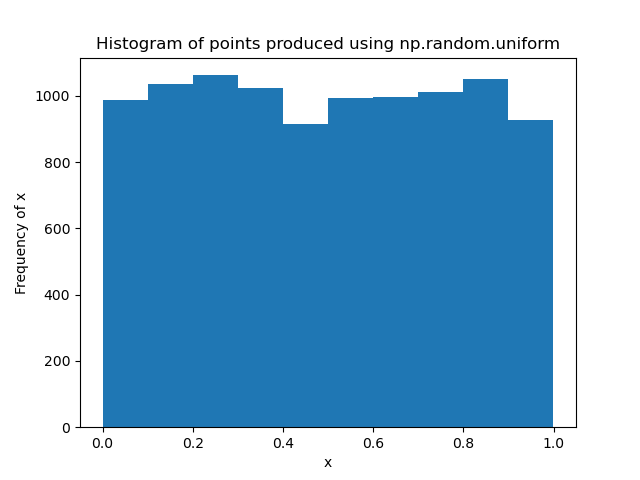

In [4]:
random_number_list = []
N_points = 10000
n_bins = 10
for i in range(0, N_points):
    random_number = np.random.uniform()
    random_number_list.append(random_number)
plt.hist(random_number_list, n_bins)
plt.xlabel('x')
plt.ylabel('Frequency of x')
plt.title('Histogram of points produced using np.random.uniform')
plt.show()

We can see for 10000 points a roughly even distribution of points is produced from the np.random.uniform function. We expect the points to behave according to a binomial distribuition. For a binomial distribution we have:
$$var(a) = np(1-p),$$
where $p$ is the probability of filling each sample, $n$ is the total number of samples, $a = np$ and $var(a)$ is the variance of the binomial distribution. The standard deviation can therefore be found from:
$$\sigma_a=\sqrt{(np(1-p)}.$$
For our case $n=10000$ and $p=0.1$, as we are using 10 bins. Therefore, $\sigma_a=30.$ This means we expect there to be fluctuations for each bin around 1000 by +-30.

# 1.1. Generating Random Points Using randssp

We can generate random points in 3D and they can be visualised by plotting. First we will use the randssp Multiplicative congruential uniform random number generator. This is based on the parameters used by IBM's Scientific Subroutine Package.

<IPython.core.display.Javascript object>


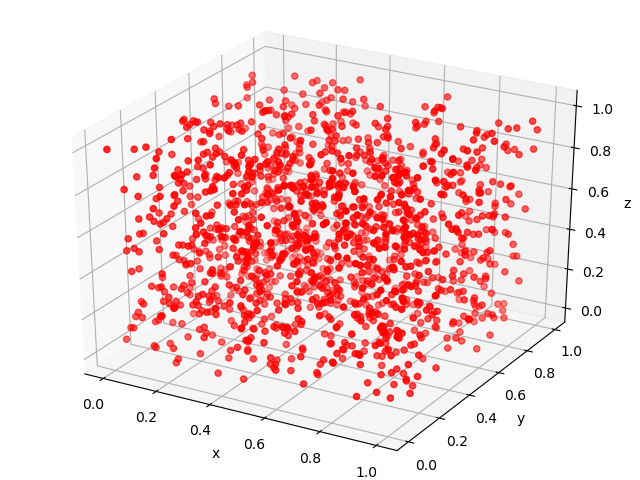

In [5]:
k = randssp(3, 1500)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(k[0, :], k[1, :], k[2, :], color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

At first glance these points seem to be randomly distributed, however when the image is rotated a clear linear correlation is found between the points. This shows the numbers generated using randssp are not random and demonstrates the spectral problem. Therefore, randssp should not be used in this investigation.

# 1.2. Generating Random Points Using np.random.uniform

We can repeat the above plot but instead generate the random points using np.random.uniform.

<IPython.core.display.Javascript object>


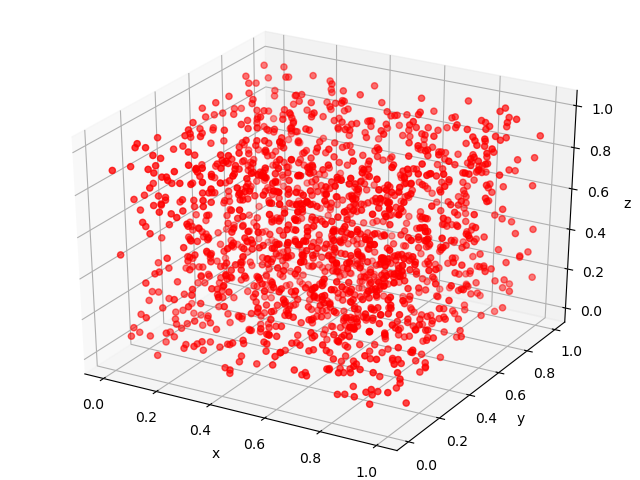

In [6]:
N_total = 40
#cretae a 3D array and genertate the numbers randomly using np.random.uniform
z = np.random.uniform(size = (N_total, N_total, N_total), low=0, high=1)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(z[0, :], z[1, :], z[2, :], color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

By rotating this figure the points do not become correlated like previously seen, therefore this method displays randomness better than randssp.

# 2.0 Modelling Absorption Of Thermal Neutrons In Water

In order to model absorption of thermal neutrons we need to gain an understanding of cross sections. The microscopic cross-section, $\sigma$, is used to describe the probability of reaction between a neutron and an individual nucleus [1]. In this case we are interested in the neutrons intercation with a nucleus from the slab of material. A neutron can have many types of interactions with a nucleus . In our case we are interested in scattering and absorption. As we have many particles in the slab of material we need to consider its number density as well. Therefore, we can write the macroscopic cross section for absorption as $$\Sigma_{abs}=\eta\sigma_{abs},$$
where $\eta$ is the number denisty of the material and $\Sigma_{abs}$ is the microscopic absorption cross section . An analogous expression for scattering can be obtained.  
$$\Sigma_{s}=\eta\sigma_{s},$$
where $\sigma_{s}$ is the microscopic cross section of scattering and $\eta$. However, initially we will assume absorption is the only process that can take place. From these macroscopic cross sections a mean free path can be calculated. This tells us how long the paricle can move freely without interaction.

# 2.1 Finding The Mean Free Path For Absorption

For thermal neutrons moving towards a slab of material the number density of the material is given by:
$$\eta = \frac{\rho N_A}{M},$$
where $\rho$ is the density of the material, $N_A$ is avogadro's number and $M$ is the molar mass of the material.
The macroscopic cross section is given by:
$$\Sigma_{abs}=\eta\sigma_{abs},$$
Now the mean free path can be calculated from:
$$\lambda=\frac{1}{\Sigma_{abs}}.$$

First we will consider water where: $\sigma_{abs}$ = 0.6652 barn, $\rho$ = 1.00 g/cm^3 and $M$ = 18.0153 g/mol.

In [7]:
cross_section_macro = number_density_tot_water * cross_section_abs_water * barn_to_cm_conversion
mean_free_path = 1 / cross_section_macro
print(('The mean free path for absorption in water is: ''{0:.4g} cm').format(mean_free_path))

The mean free path for absorption in water is: 44.97 cm


# 2.2 Creating A Exponential Distribuition Of Points 

We can use the inverse distribuition method for generating sample numbers at random from any probability distribution [2]. For our case we require an exponential distribuition. The method to generate these sample numbers is outlined below.

An exponential probability density distribuition is given by:
$$pdf(x)=e^{-x},$$
where x is some randomly generated number using np.random.uniform.
We can find the cumalitive probability ditribuition by taking the integral of $pdf(x)$.
$$cdf(x)= \int_{0}^{x}pdf(x)=\int_{0}^{x}e^{-x}=1-e^{-x}.$$
Now the inverse cumalitive probability ditribuition can be obtained to give:
$$cdf^{-1}(x)=-\log(1-x).$$
As x is some random number so is $1-x$ therefore, we can rewrite the above expressions as:
$$cdf^{-1}(x)=-\log(x),$$
and if we include the mean free path we finally arrive at:
$$s_i = -\lambda\log(x_i),$$
where $x_i$ refers to the $i^{th}$ randomly generated number and $s_i$ is a random step of the thermal neutron. So, what we have done here is generate steps our neutron can take, where the steps are found according to an exponential distribuition.


<IPython.core.display.Javascript object>


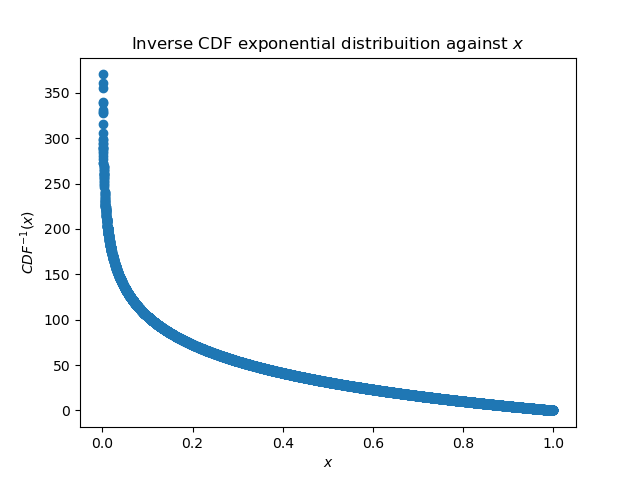

In [8]:
N_total = 10000 # Number of thermal neutrons 
x_values = np.random.uniform(size = (N_total), low=0, high=1)
#plot the inverse CDF for an exponential function including the mean free path
CDF_inverse = -mean_free_path * np.log(x_values)
#find variables NR and Ri from the data
#plot the inverse CDF for an exponential distribuition 
fig_1, axs_1 = plt.subplots(1)
axs_1.scatter(x_values, CDF_inverse)
axs_1.set_title('Inverse CDF exponential distribuition against $x$')
axs_1.set_xlabel('$x$')
axs_1.set_ylabel('$CDF^{-1}(x)$')
plt.show()

By using the $cdf^{-1}$ distribuition we can obtain values for the number of particles,$N_R$ and the depth of the particle $R_i$. These are obtained by plotting a histogram.

<IPython.core.display.Javascript object>


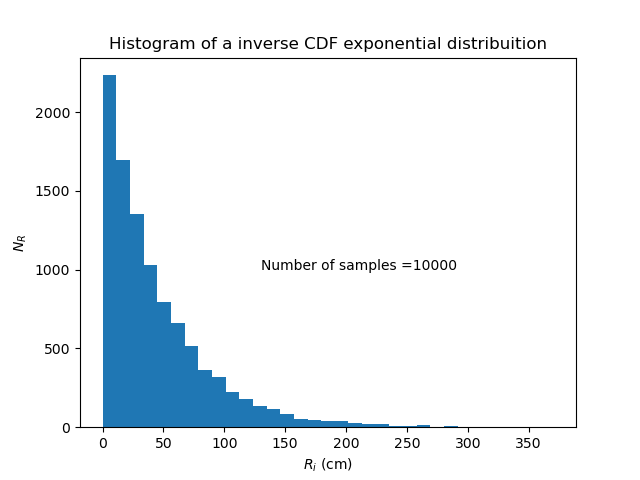

In [9]:
#plot a histogram of the inverse CDF for an exponential distribuition 
fig_1, axs_1 = plt.subplots(1)
axs_1.hist(CDF_inverse, bins=33)
axs_1.set_title('Histogram of a inverse CDF exponential distribuition')
axs_1.set_xlabel('$R_i$ (cm)')
axs_1.set_ylabel('$N_R$')
#add text to the plot
plt.text(130, 1000,'Number of samples =' + str(N_total))
plt.show()

The relationship between $N_R$ and $R_i$ is expressed as:
$$N_R=e^{\frac{-R_i}{\lambda}}.$$
By taking the log we can obtain a straight line fit of the form:
$$\ln(N_R)=-\frac{R_i}{\lambda}.$$
We can therefore plot a straight line graph where $\ln(N_R)$ is on the y-axis and $R_i$ is on the x-axis. This gives a gradient of $-\frac{1}{\lambda}$, hence $\lambda$ can be found. The difference between the $\lambda$ found from the water data and the one found from this linear fit can be found and the error on the fitted $\lambda$ is obtained by the fitting algorithm.

<IPython.core.display.Javascript object>


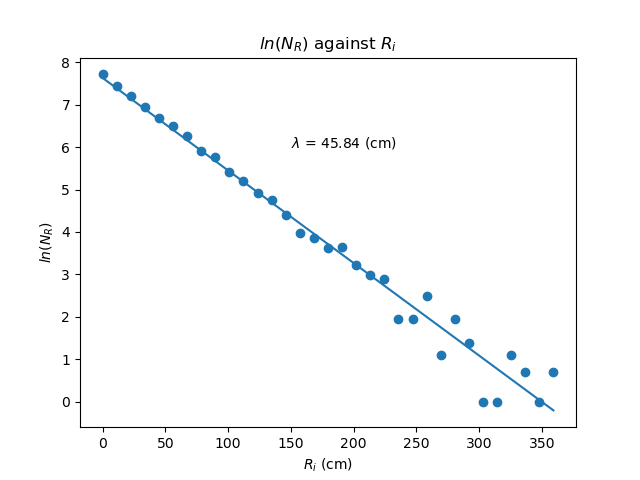

--------------------
Results
--------------------
Difference Between The Analytical Mean Free Path And The Fitted, For Water Absorption Is: 0.8723 cm
Fitted Total Mean Free Path For Water Absortpion: (45.84 +/- 1.29) cm


In [10]:
#find NR and Ri from the histogram data
NR, Ri = np.histogram(CDF_inverse, bins=33)
#Remove points where NR=0 as the ln(0) is not defined
NR_new, Ri_new = data_cleaner_1(NR, Ri)
#fit the data to find the mean free path value and its error
mean_free_path_fitted, mean_free_path_error, m, c = fit_data_1(Ri_new, NR_new)
#plot a linear fit of ln(NR) against Ri
fig_3, axs_3 = plt.subplots(1)
axs_3.scatter(Ri_new, np.log(NR_new))
axs_3.set_title('$ln(N_R)$ against $R_i$')
axs_3.set_xlabel('$R_i$ (cm)')
axs_3.set_ylabel('$ln(N_R)$')
plt.text(150, 6,(('$\lambda$ = ''{0:.4g} (cm)').format(mean_free_path_fitted)))
#on the same axis plot the line of best fit
axs_3.plot(Ri_new, m * Ri_new + c)
#print results
print('--------------------')
print('Results')
print('--------------------')
print(('Difference Between The Analytical Mean Free Path And The Fitted, For Water Absorption Is: ''{0:.4g} cm')\
      .format(mean_free_path_fitted - mean_free_path))
print(('Fitted Total Mean Free Path For Water Absortpion: ''({0:.2f} +/- {1:.2f}) cm').format(mean_free_path_fitted, 
                                                                          mean_free_path_error))
plt.show()

By looking at the above figure we see at low values of $R_i$ the points are fitted well with the line of best fit, however, as $R_i$ increases the points fit worse. This makes sense as we are plotting a $log$ on the y axis. When calcualting the errors in a $log$ we take the derivative. The derivative of $log(N_R)$ is $\frac{1}{N_R}$, therefore, as $N_R$ decreases the error gets larger and the further the points are from the line of best fit. This is what we see in the graph above.

# 3.0 Modelling Absorption ,Scattering And Transmission For Water, Lead and Graphene

# 3.1 Generating Points Uniformly Distributed On A Sphere

When a thermal neutron collides with a slab of material it can be scattered in any direction equally. This region is defined by a uniformly distributed spherical region, therefore, generating this distribuition is vital for the description of scattering thermal neutrons.

<IPython.core.display.Javascript object>


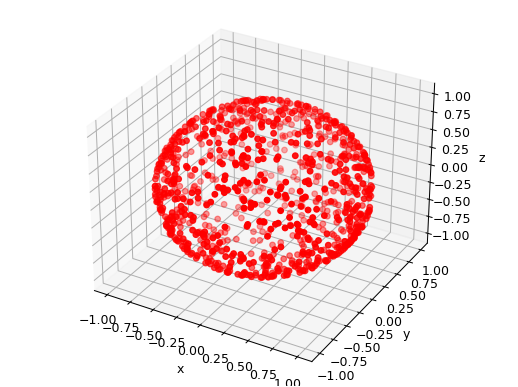

In [11]:
data_points = 1000
#get all the points used for the plot
vect = combination_of_vectors(data_points)
#find x, y and z
x = vect[:, 0]
y = vect[:, 1]
z = vect[:, 2]
#plot on 3D axis
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z, color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Visually we can see, by rotating this spherical distribuition, that it is uniform and does not suffer from concentrated poles. This is important as we do not want to introduce any bias into our simulation.

# 3.2 Finding The Total Mean Free Path 

Thermal neutrons can be scattered or absorved by the slab of material. For both processes there is an associated macroscopic cross section given by:
$$\Sigma_{\alpha}=\eta_{\alpha}\sigma_{\alpha},$$
where $\sigma_{\alpha}$ is the microscopic cross section of absorption and $\eta_{\alpha}$ is the number density of absorption and:
$$\Sigma_{s}=\eta_{s}\sigma_{s},$$
where $\sigma_{s}$ is the microscopic cross section of scattering and $\eta_{s}$ is the number density of scattering.
We then obtain the total macroscopic absorption by:
$$\Sigma_{T}=\Sigma_{\alpha}+\Sigma_{s}.$$
The total mean free path can be obtained by:
$$\lambda_T=\frac{1}{\Sigma_T}.$$
This mean free path value can now be used in the simulation to model scattering and absorption.



In [12]:
#find the total mean free path for water, lead and graphite
#for water
mean_free_path_total_water, macroscopic_cross_section_abs_water, macroscopic_cross_section_tot_water = \
total_mean_free_path_calculator(cross_section_scat_water, cross_section_abs_water, number_density_tot_water)
#for lead
mean_free_path_total_lead, macroscopic_cross_section_abs_lead, macroscopic_cross_section_tot_lead = \
total_mean_free_path_calculator(cross_section_scat_lead, cross_section_abs_lead, number_density_tot_lead)
#for graphite
mean_free_path_total_graphite, macroscopic_cross_section_abs_graphite, macroscopic_cross_section_tot_graphite = \
total_mean_free_path_calculator(cross_section_scat_graphite, cross_section_abs_graphite, number_density_tot_graphite)

# 3.3 Running The Simulation

For the simulation we can imagine a thermal neutron moving in the possitive x direction. We can then implement a displacement step given by $S_i$. After this step we can check if the neutron has been absorbed, scattered or transmitted. Clearly if the neutrons final possition is greater than the lenght of the slab, it must have been transmitted. If the neutrons final possition is less than the lenght of the slab it must have been reflected. It isnt as clear to justfy if the particle has been absorbed or scattered at each step. We can do this by finding a probability of absorption, given by:
$$P_{a} = \frac{\Sigma_{a}}{\Sigma{a} + \Sigma{s}}.$$
We then generate a random number $u$ between 0 and 1. if $u < P_{a}$ we can say the neutron has been absorbed and its path through the slab will be stopped. Otherwise, the neutron has been scattered, where we then repeat the process until it has left the slab or been absorbed. In order to ensure this is a random process each step other than the first, has to be in a randomised direction according to the spherical distribuition explained above. If this spherical distribuition suffered from concentrated poles the simulation would not give random vectors for the neutrons to move along, hence confirming the importance of the above investigation. We can then repeat the simulation for a specified number of neutrons and the number of neutrons transmitted, scattered and transmitted can be found. Then we can plot the random walk of a particle for a given material.

<IPython.core.display.Javascript object>


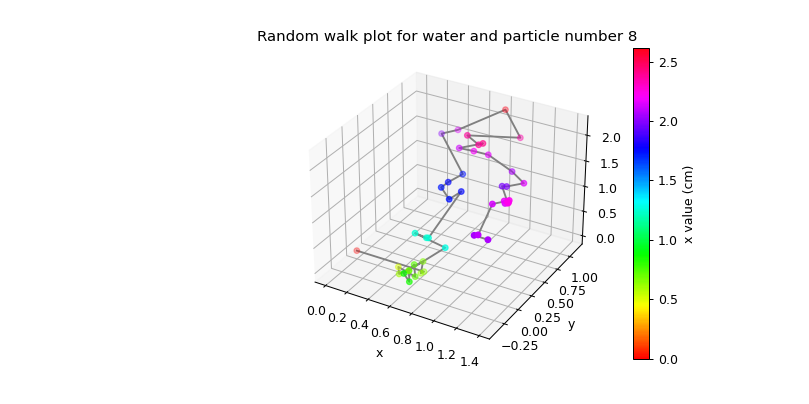

<IPython.core.display.Javascript object>


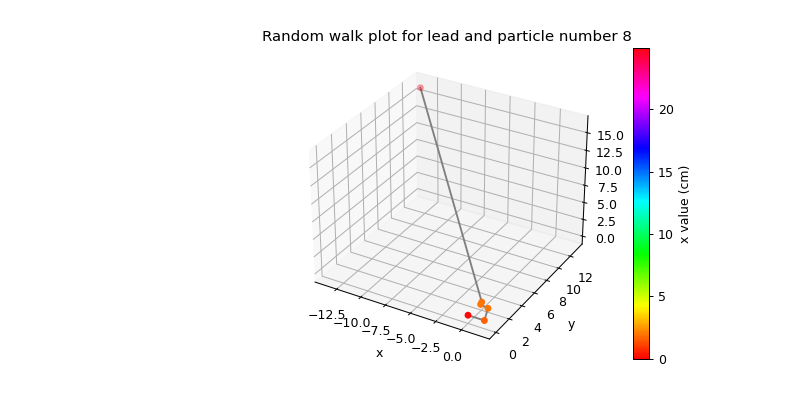

<IPython.core.display.Javascript object>


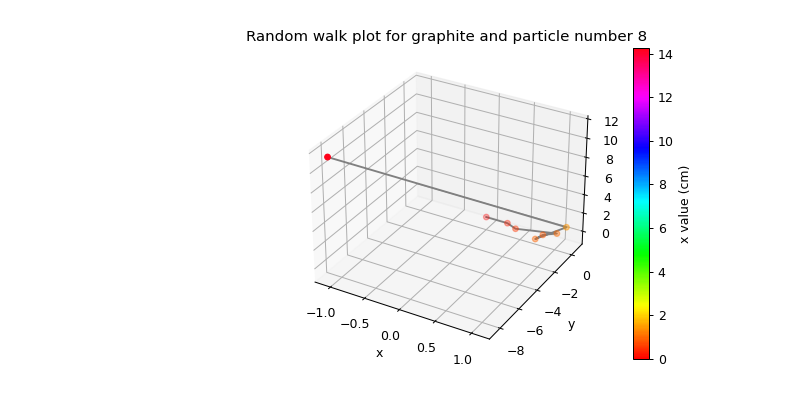

In [13]:
T = 10 #thickness of the slab in cm
number_of_particles = 1000 #total number of particles that will be simulated
#find the trajectories for all particles in each material
trajectories_water = scattering_absorption_simulation(mean_free_path_total_water, macroscopic_cross_section_abs_water\
                                                      ,macroscopic_cross_section_tot_water, number_of_particles, T)
trajectories_lead = scattering_absorption_simulation(mean_free_path_total_lead, macroscopic_cross_section_abs_lead\
                                                      ,macroscopic_cross_section_tot_lead, number_of_particles, T)
trajectories_graphite = scattering_absorption_simulation(mean_free_path_total_graphite, macroscopic_cross_section_abs_graphite\
                                                      ,macroscopic_cross_section_tot_graphite, number_of_particles, T)
particle_number_water = 8 #the particle whose random walk will be plotted
particle_number_lead = 8 #the particle whose random walk will be plotted
particle_number_graphite = 8 #the particle whose random walk will be plotted
#plot the random walk for water
plot_random_walk(trajectories_water, particle_number_water, 'water')
#plot the random walk for lead
plot_random_walk(trajectories_lead, particle_number_lead, 'lead')
#plot the random walk for graphite
plot_random_walk(trajectories_graphite, particle_number_graphite, 'graphite')

# 3.4 Finding the fraction of incident neutrons absorbed, reflected and                transmitted

First we will run the simulation once and the number of neutrons absorbed, reflected and transmitted will be calculated for each material.

In [14]:
#find the number of neutrons transmitted, reflected and absorbed
number_transmitted_water, number_reflected_water, number_absorbed_water = final_particle_state(trajectories_water, T)
number_transmitted_lead, number_reflected_lead, number_absorbed_lead = final_particle_state(trajectories_lead, T)
number_transmitted_graphite, number_reflected_graphite, number_absorbed_graphite = final_particle_state(trajectories_graphite, 
                                                                                                        T)
#now find the fractions
#for water
fraction_transmitted_water = number_transmitted_water / number_of_particles
fraction_absorbed_water = number_absorbed_water / number_of_particles
fraction_reflected_water = number_reflected_water / number_of_particles
#for lead
fraction_transmitted_lead = number_transmitted_lead / number_of_particles
fraction_absorbed_lead = number_absorbed_lead / number_of_particles
fraction_reflected_lead = number_reflected_lead / number_of_particles
#for graphite
fraction_transmitted_graphite = number_transmitted_graphite / number_of_particles
fraction_absorbed_graphite = number_absorbed_graphite / number_of_particles
fraction_reflected_graphite = number_reflected_graphite / number_of_particles
#print results
#for water
print('------------------------')
print('Transmission For A Fixed Thickness - Water')
print('------------------------')
print('Thickness: ' , T, 'cm')
print('Total Neutrons: ', number_of_particles,)
print('Neutrons Reflected: ', number_reflected_water)
print('Neutrons Absorbed: ', number_absorbed_water)
print('Neutrons Transmitted: ', number_transmitted_water)
print(('Percentage Transmitted: ''{0:.1f}').format(fraction_transmitted_water * 100))
print(('Percentage Reflected: ''{0:.1f}').format(fraction_reflected_water * 100))
print(('Percentage Absorbed: ''{0:.1f}').format(fraction_absorbed_water * 100))
#for lead
print('------------------------')
print('Transmission For A Fixed Thickness - Lead')
print('------------------------')
print('Thickness: ' , T, 'cm')
print('Total Neutrons: ', number_of_particles,)
print('Neutrons Reflected: ', number_reflected_lead)
print('Neutrons Absorbed: ', number_absorbed_lead)
print('Neutrons Transmitted: ', number_transmitted_lead)
print(('Percentage Transmitted: ''{0:.1f}').format(fraction_transmitted_lead * 100))
print(('Percentage Reflected: ''{0:.1f}').format(fraction_reflected_lead * 100))
print(('Percentage Absorbed: ''{0:.1f}').format(fraction_absorbed_lead * 100))
#for graphite
print('------------------------')
print('Transmission For A Fixed Thickness - Graphite')
print('------------------------')
print('Thickness: ' , T, 'cm')
print('Total Neutrons: ', number_of_particles,)
print('Neutrons Reflected: ', number_reflected_graphite)
print('Neutrons Absorbed: ', number_absorbed_graphite)
print('Neutrons Transmitted: ', number_transmitted_graphite)
print(('Percentage Transmitted: ''{0:.1f}').format(fraction_transmitted_graphite * 100))
print(('Percentage Reflected: ''{0:.1f}').format(fraction_reflected_graphite * 100))
print(('Percentage Absorbed: ''{0:.1f}').format(fraction_absorbed_graphite * 100))

------------------------
Transmission For A Fixed Thickness - Water
------------------------
Thickness:  10 cm
Total Neutrons:  1000
Neutrons Reflected:  789
Neutrons Absorbed:  206
Neutrons Transmitted:  5
Percentage Transmitted: 0.5
Percentage Reflected: 78.9
Percentage Absorbed: 20.6
------------------------
Transmission For A Fixed Thickness - Lead
------------------------
Thickness:  10 cm
Total Neutrons:  1000
Neutrons Reflected:  614
Neutrons Absorbed:  106
Neutrons Transmitted:  280
Percentage Transmitted: 28.0
Percentage Reflected: 61.4
Percentage Absorbed: 10.6
------------------------
Transmission For A Fixed Thickness - Graphite
------------------------
Thickness:  10 cm
Total Neutrons:  1000
Neutrons Reflected:  712
Neutrons Absorbed:  7
Neutrons Transmitted:  281
Percentage Transmitted: 28.1
Percentage Reflected: 71.2
Percentage Absorbed: 0.7


It is difficult to draw concrete conclusions from these results as we have only ran the simulation once. Everytime we run this simulation we will get a different answer as we are modelling a random process. To mitigate against this problem we can run the simulation multiple times and an average value of neutrons absorbed $N_a$, transmitted $N_t$ and reflected $N_r$ can be found. We can imagine a graph of $N_a$, $N_t$ or $N_r$ plotted against their corresponding frequency. This graph would be a normal distribuition. Therefore, the error on $N_a$, $N_t$ and $N_r$ can be found from the standard deviation, $\sigma$, of the normal distribuition.

In [15]:
number_of_particles = 100
trial_number = 100 #number of times we run the simulation
#find how many particles are transmitted, absorbed and reflected
#for water
transmitted_mean_water, reflected_mean_water, absorbed_mean_water, transmitted_stdev_water, reflected_stdev_water,\
absorbed_stdev_water = multiple_trials(mean_free_path_total_water, macroscopic_cross_section_abs_water, \
                                       macroscopic_cross_section_tot_water, number_of_particles, T, trial_number)
#for lead
transmitted_mean_lead, reflected_mean_lead, absorbed_mean_lead, transmitted_stdev_lead, reflected_stdev_lead,\
absorbed_stdev_lead = multiple_trials(mean_free_path_total_lead, macroscopic_cross_section_abs_lead, \
                                       macroscopic_cross_section_tot_lead, number_of_particles, T, trial_number)
#for graphite
transmitted_mean_graphite, reflected_mean_graphite, absorbed_mean_graphite, transmitted_stdev_graphite,\
reflected_stdev_graphite, absorbed_stdev_graphite = multiple_trials(mean_free_path_total_graphite, 
                                                    macroscopic_cross_section_abs_graphite, 
                                                macroscopic_cross_section_tot_graphite, number_of_particles, T, trial_number)
#now find the fractions
#for water
fraction_transmitted_water = transmitted_mean_water / number_of_particles
fraction_absorbed_water = absorbed_mean_water / number_of_particles
fraction_reflected_water = reflected_mean_water / number_of_particles
#for lead
fraction_transmitted_lead = transmitted_mean_lead / number_of_particles
fraction_absorbed_lead = absorbed_mean_lead / number_of_particles
fraction_reflected_lead = reflected_mean_lead / number_of_particles
#for graphite
fraction_transmitted_graphite = transmitted_mean_graphite / number_of_particles
fraction_absorbed_graphite = absorbed_mean_graphite / number_of_particles
fraction_reflected_graphite = reflected_mean_graphite / number_of_particles
#now find the fractions errors
#for water
transmitted_percent_error_water, absorbed_percent_error_water, reflected_percent_error_water = percent_error_calculator(
    transmitted_stdev_water, absorbed_stdev_water, reflected_stdev_water)
#for lead
transmitted_percent_error_lead, absorbed_percent_error_lead, reflected_percent_error_lead = percent_error_calculator(
    transmitted_stdev_lead,absorbed_stdev_lead, reflected_stdev_lead)
#for graphite
transmitted_percent_error_graphite, absorbed_percent_error_graphite, reflected_percent_error_graphite = \
percent_error_calculator(transmitted_stdev_graphite, absorbed_stdev_graphite, reflected_stdev_graphite)

#print results
print('NUMBER OF TRIALS IS: ', trial_number)
#for water
print('------------------------')
print('Transmission For A Fixed Thickness - Water')
print('------------------------')
print('Thickness: ' , T, 'cm')
print('Total Neutrons: ', number_of_particles,)
print(('Mean Number Of Neutrons Reflected: ''({0:.2f} +/- {1:.2f})').format(reflected_mean_water, reflected_stdev_water))
print(('Mean Number Of Neutrons Absorbed: ''({0:.2f} +/- {1:.2f})').format(absorbed_mean_water, absorbed_stdev_water))
print(('Mean Number Of Neutrons Transmitted: ''({0:.2f} +/- {1:.2f})').format(transmitted_mean_water, transmitted_stdev_water))
print(('Mean Percentage Transmitted: ''({0:.1f} +/- {1:.2f})').format(fraction_transmitted_water * 100, 
                                                                      transmitted_percent_error_water))
print(('Mean Percentage Reflected: ''({0:.1f} +/- {1:.2f})').format(fraction_reflected_water * 100, 
                                                                      reflected_percent_error_water))
print(('Mean Percentage Absorbed: ''({0:.1f} +/- {1:.2f})').format(fraction_absorbed_water * 100, 
                                                                      absorbed_percent_error_water))
#for lead
print('------------------------')
print('Transmission For A Fixed Thickness - Lead')
print('------------------------')
print('Thickness: ' , T, 'cm')
print('Total Neutrons: ', number_of_particles,)
print(('Mean Number Of Neutrons Reflected: ''({0:.2f} +/- {1:.2f})').format(reflected_mean_lead, reflected_stdev_lead))
print(('Mean Number Of Neutrons Absorbed: ''({0:.2f} +/- {1:.2f})').format(absorbed_mean_lead, absorbed_stdev_lead))
print(('Mean Number Of Neutrons Transmitted: ''({0:.2f} +/- {1:.2f})').format(transmitted_mean_lead, transmitted_stdev_lead))
print(('Mean Percentage Transmitted: ''({0:.1f} +/- {1:.2f})').format(fraction_transmitted_lead * 100, 
                                                                      transmitted_percent_error_lead))
print(('Mean Percentage Reflected: ''({0:.1f} +/- {1:.2f})').format(fraction_reflected_lead * 100, 
                                                                      reflected_percent_error_lead))
print(('Mean Percentage Absorbed: ''({0:.1f} +/- {1:.2f})').format(fraction_absorbed_lead * 100, 
                                                                      absorbed_percent_error_lead))
#for graphite
print('------------------------')
print('Transmission For A Fixed Thickness - Graphite')
print('------------------------')
print('Thickness: ' , T, 'cm')
print('Total Neutrons: ', number_of_particles,)
print(('Mean Number Of Neutrons Reflected: ''({0:.2f} +/- {1:.2f})').format(reflected_mean_graphite, reflected_stdev_graphite))
print(('Mean Number Of Neutrons Absorbed: ''({0:.2f} +/- {1:.2f})').format(absorbed_mean_graphite, absorbed_stdev_graphite))
print(('Mean Number Of Neutrons Transmitted: ''({0:.2f} +/- {1:.2f})').format(transmitted_mean_graphite, 
                                                                              transmitted_stdev_graphite))
print(('Mean Percentage Transmitted: ''({0:.1f} +/- {1:.2f})').format(fraction_transmitted_graphite * 100, 
                                                                      transmitted_percent_error_graphite))
print(('Mean Percentage Reflected: ''({0:.1f} +/- {1:.2f})').format(fraction_reflected_graphite * 100, 
                                                                      reflected_percent_error_graphite))
print(('Mean Percentage Absorbed: ''({0:.1f} +/- {1:.2f})').format(fraction_absorbed_graphite * 100, 
                                                                      absorbed_percent_error_graphite))

NUMBER OF TRIALS IS:  100
------------------------
Transmission For A Fixed Thickness - Water
------------------------
Thickness:  10 cm
Total Neutrons:  100
Mean Number Of Neutrons Reflected: (79.46 +/- 3.73)
Mean Number Of Neutrons Absorbed: (20.18 +/- 3.75)
Mean Number Of Neutrons Transmitted: (0.36 +/- 0.74)
Mean Percentage Transmitted: (0.4 +/- 0.74)
Mean Percentage Reflected: (79.5 +/- 3.73)
Mean Percentage Absorbed: (20.2 +/- 3.75)
------------------------
Transmission For A Fixed Thickness - Lead
------------------------
Thickness:  10 cm
Total Neutrons:  100
Mean Number Of Neutrons Reflected: (62.77 +/- 4.90)
Mean Number Of Neutrons Absorbed: (9.90 +/- 3.28)
Mean Number Of Neutrons Transmitted: (27.33 +/- 4.59)
Mean Percentage Transmitted: (27.3 +/- 4.59)
Mean Percentage Reflected: (62.8 +/- 4.90)
Mean Percentage Absorbed: (9.9 +/- 3.28)
------------------------
Transmission For A Fixed Thickness - Graphite
------------------------
Thickness:  10 cm
Total Neutrons:  100
Mean N

These results provide a more accurate description of $N_a$, $N_t$ and $N_r$ for each slab material. We can see that the average $N_t$ is smallest for water and largest for graphite. Consequently, $N_a$  is largest for water and smallest for graphite. Finally $N_r$ is largest for water but smallest for lead.

Now we want to see how this error in $N_a$, $N_t$ and $N_r$ varys with number of simulated particles. For clarity we will see how the errors change just for lead.

<IPython.core.display.Javascript object>


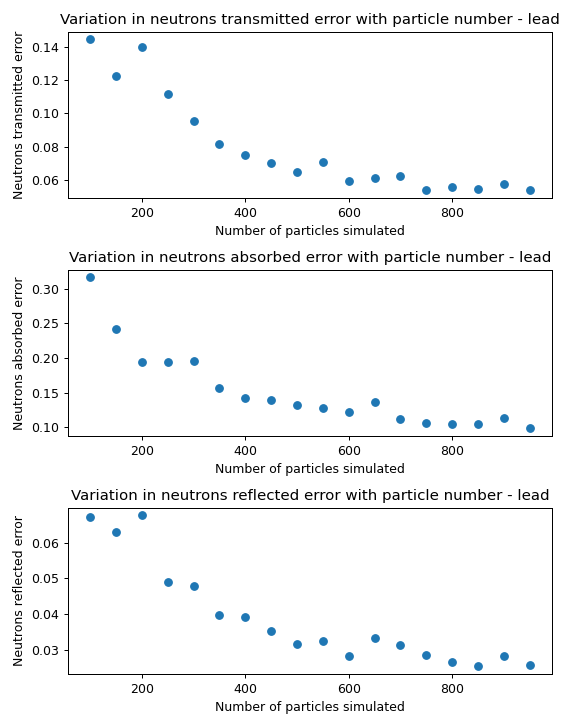

[]

In [16]:
number_of_particles_range = np.arange(100, 1000, 50) #array containing different numbers of neutrons we want to simulate
transmitted_fractional_stdev_array, reflected_fractional_stdev_array, absorbed_fractional_stdev_array = \
                                                                            error_changing_particle_number_calculator(
                                                                            mean_free_path_total_lead, 
                                                                                macroscopic_cross_section_abs_lead, \
                                                macroscopic_cross_section_tot_lead, number_of_particles_range, T, trial_number)
# for lead
fig_1, axs_1 = plt.subplots(3, 1, figsize=(7, 9), tight_layout=True)
axs_1[0].scatter(number_of_particles_range, transmitted_fractional_stdev_array )
axs_1[0].set_title('Variation in neutrons transmitted error with particle number - lead')
axs_1[0].set_xlabel('Number of particles simulated')
axs_1[0].set_ylabel('Neutrons transmitted error')
axs_1[1].scatter(number_of_particles_range, absorbed_fractional_stdev_array)
axs_1[1].set_title('Variation in neutrons absorbed error with particle number - lead')
axs_1[1].set_xlabel('Number of particles simulated')
axs_1[1].set_ylabel('Neutrons absorbed error')
axs_1[2].scatter(number_of_particles_range, reflected_fractional_stdev_array)
axs_1[2].set_title('Variation in neutrons reflected error with particle number - lead')
axs_1[2].set_xlabel('Number of particles simulated')
axs_1[2].set_ylabel('Neutrons reflected error')
plt.plot()

Clearly we can see that the error decreases for an increase in the number of particles simulated. So as the number of particles increases the accuracy of the simulation increases. This is expected as the error is given by a standard deviation which is proportional to $\frac{1}{N}$, where $N$ is the number of particles in the distribuition. For our case $N$ is $N_t$, $N_r$ or $N_a$. Therefore as $N$ increases or number of particles simulated increases the error will reduce.

# 3.5 Varying The Thickness Of The Slab

Now we can look at how the number of $N_t$, $N_r$ and $N_a$ vary with slab thickness for each material. The errors are obtained in the same way as done previously, i.e by assuming a normal distribuition.

In [17]:
thickness = np.arange(0.01, 30, 0.4) #thickness of the slab in cm
trial_number = 10 #this is the number of times we want our simulation to run in order to caluclate the errors
#for water
water_array_transmitted, water_array_absorbed, water_array_reflected, water_array_transmitted_stdev,\
water_array_absorbed_stdev, water_array_reflected_stdev = vary_thickness(thickness, mean_free_path_total_water,\
                                                                                      macroscopic_cross_section_abs_water\
                                                              ,macroscopic_cross_section_tot_water, number_of_particles, 
                                                                                      trial_number)
#for lead
lead_array_transmitted, lead_array_absorbed, lead_array_reflected, lead_array_transmitted_stdev, lead_array_absorbed_stdev,\
lead_array_reflected_stdev = vary_thickness(thickness, mean_free_path_total_lead,\
                                                                                      macroscopic_cross_section_abs_lead\
                                                              ,macroscopic_cross_section_tot_lead, number_of_particles,
                                                                                   trial_number)
#for graphite
graphite_array_transmitted, graphite_array_absorbed, graphite_array_reflected, graphite_array_transmitted_stdev,\
graphite_array_absorbed_stdev, graphite_array_reflected_stdev = vary_thickness(thickness, mean_free_path_total_graphite,
                                                                                      macroscopic_cross_section_abs_graphite\
                                                              ,macroscopic_cross_section_tot_graphite, number_of_particles,
                                                                                               trial_number)

Now we can plot the reults for each material

<IPython.core.display.Javascript object>


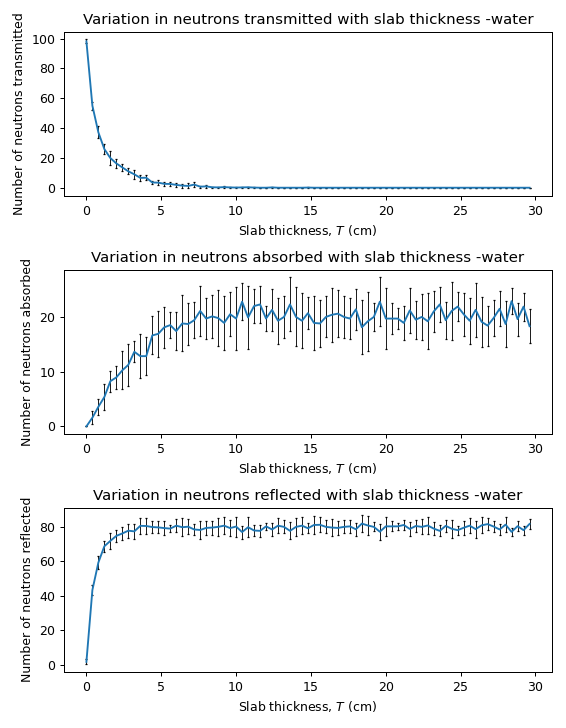

In [18]:
#for water
plot_subplots('water', thickness, water_array_transmitted, water_array_transmitted_stdev, water_array_absorbed, 
              water_array_absorbed_stdev, water_array_reflected, water_array_reflected_stdev)

<IPython.core.display.Javascript object>


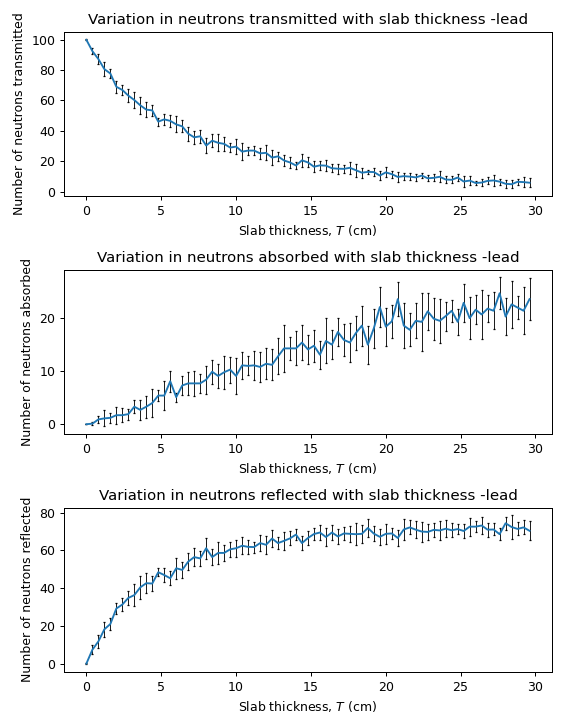

In [19]:
#for lead
plot_subplots('lead', thickness, lead_array_transmitted, lead_array_transmitted_stdev, lead_array_absorbed, 
              lead_array_absorbed_stdev, lead_array_reflected, lead_array_reflected_stdev)

<IPython.core.display.Javascript object>


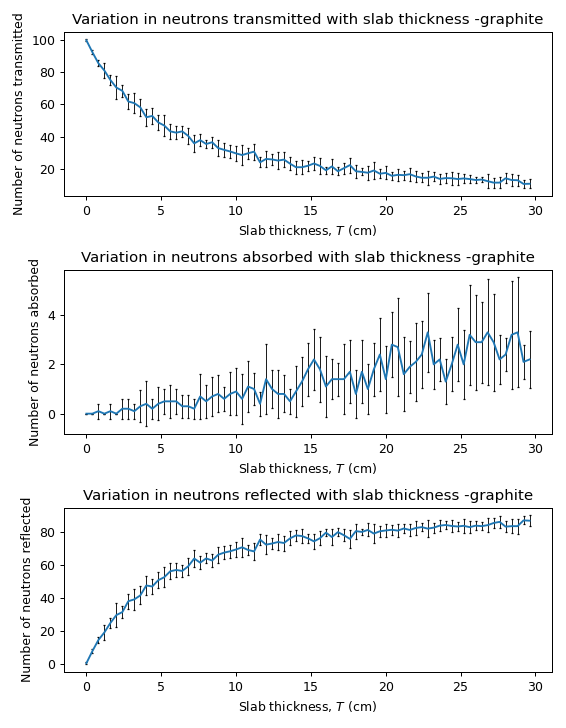

In [20]:
#for graphite
plot_subplots('graphite', thickness, graphite_array_transmitted, graphite_array_transmitted_stdev, graphite_array_absorbed, 
              graphite_array_absorbed_stdev, graphite_array_reflected, graphite_array_reflected_stdev)

All the materials follow similiar trends. The number of neutrons transmitted decreases exponetially with increasing slab thickness. This makes sense beacause as the slab thickness increases there will be more collisions of the incoming neutrons, therefore, fewer will get through the slab. The number of neutrons reflected increases according to a log trend with increasing slab thickness. Again this can be explained by the previous reasoning. One important difference is that the number of neutrons absorbed for water seems to follow a log trend but that for lead and graphite is linear. As a log increases quicker than a linear trend, water will absorb more neutrons quicker than for lead and graphite. To re-enforce this point a fit of the data can be done. The equation of the curve or line can then be found and these can be compared for each material.

Another interesting application of thes results is in nuclear fission. In this process neutrons are needed to instigate the process and many neutrons are produced in a chain reaction. The reaction can happen too quick, i.e when too many neutrons are produced. We can prevent this by introducing control rods that absorb neutrons. In this case water would be the best material to use.

The equation of the curve or line can then be found and these can be compared for each material. Now lets perform these fits.

In [21]:
#for water
#first we fit a decreasing exponential for the neutrons transmitted
m_transmitted_water, c_transmitted_water, sigma_m_transmitted_water, sigma_c_transmitted_water = fit_data_2(
                                                                    'exponential decrease', thickness, water_array_transmitted)
#now fit a log for the neutrons absorbed
m_absorbed_water, c_absorbed_water, sigma_m_absorbed_water, sigma_c_absorbed_water = fit_data_2('log'
                                                                                        , thickness, water_array_absorbed)
#now fit a log for the neutrons reflected
m_reflected_water, c_reflected_water, sigma_m_reflected_water, sigma_c_reflected_water = fit_data_2('log'
                                                                                        , thickness, water_array_reflected)
#for lead
m_transmitted_lead, c_transmitted_lead, sigma_m_transmitted_lead, sigma_c_transmitted_lead = fit_data_2('exponential decrease'
                                                                                        , thickness, lead_array_transmitted)
#now fit a linear trend for the neutrons absorbed
m_absorbed_lead, c_absorbed_lead, sigma_m_absorbed_lead, sigma_c_absorbed_lead = fit_data_2('linear'
                                                                                        , thickness, lead_array_absorbed)
#now fit a log for the neutrons reflected
m_reflected_lead, c_reflected_lead, sigma_m_reflected_lead, sigma_c_reflected_lead = fit_data_2('log'
                                                                                        , thickness, lead_array_reflected)
#for graphite
m_transmitted_graphite, c_transmitted_graphite, sigma_m_transmitted_graphite, sigma_c_transmitted_graphite =\
                                                    fit_data_2('exponential decrease', thickness, graphite_array_transmitted)
#now fit a linear trend for the neutrons absorbed
m_absorbed_graphite, c_absorbed_graphite, sigma_m_absorbed_graphite, sigma_c_absorbed_graphite = fit_data_2('linear'
                                                                                        , thickness, graphite_array_absorbed)
#now fit a log for the neutrons reflected
m_reflected_graphite, c_reflected_graphite, sigma_m_reflected_graphite, sigma_c_reflected_graphite = fit_data_2('log'
                                                                                        , thickness, graphite_array_reflected)

#print the equation for the transmitted neutrons
#for water
print('--------------')
print('Water Results:')
print('--------------')
print_equation('water', 'transmitted', m_transmitted_water, sigma_m_transmitted_water, c_transmitted_water, 
               sigma_c_transmitted_water)
#print the equation for the absorbed neutrons
print_equation('water', 'absorbed', m_absorbed_water, sigma_m_absorbed_water, c_absorbed_water, sigma_c_absorbed_water)
#print the equation for the reflected neutrons
print_equation('water', 'reflected',m_reflected_water,sigma_m_reflected_water, c_reflected_water, sigma_c_reflected_water)
#for lead
print('--------------')
print('Lead Results:')
print('--------------')
print_equation('lead', 'transmitted', m_transmitted_lead, sigma_m_transmitted_lead, c_transmitted_lead, 
               sigma_c_transmitted_lead)
#print the equation for the absorbed neutrons
print_equation('lead', 'absorbed', m_absorbed_lead, sigma_m_absorbed_lead, c_absorbed_lead, sigma_c_absorbed_lead)
#print the equation for the reflected neutrons
print_equation('lead', 'reflected',m_reflected_lead, sigma_m_reflected_lead, c_reflected_lead, sigma_c_reflected_lead)
#for graphite
print('--------------')
print('Graphite Results:')
print('--------------')
print_equation('graphite', 'transmitted', m_transmitted_graphite, sigma_m_transmitted_graphite, c_transmitted_graphite, 
               sigma_c_transmitted_graphite)
#print the equation for the absorbed neutrons
print_equation('lead', 'absorbed', m_absorbed_graphite, sigma_m_absorbed_graphite, c_absorbed_graphite, 
               sigma_c_absorbed_graphite)
#print the equation for the reflected neutrons
print_equation('lead', 'reflected',m_reflected_graphite, sigma_m_reflected_graphite, c_reflected_graphite, 
               sigma_c_reflected_graphite)

--------------
Water Results:
--------------
The equation describing the number of neutrons transmitted is: N_t =(92.7 +/- 1.45) * exp(-T) + (0.6 +/- 0.22)
The equation describing the number of neutrons absorbed is: N_t =(3.4 +/- 0.22) * ln(T) + (10.3 +/- 0.59)
The equation describing the number of neutrons absorbed is: N_t =(7.0 +/- 0.54) * ln(T) + (61.0 +/- 1.43)
--------------
Lead Results:
--------------
The equation describing the number of neutrons transmitted is: N_t =(110.0 +/- 12.83) * exp(-T) + (22.8 +/- 1.98)
The equation describing the number of neutrons absorbed is: N_t =(0.8 +/- 0.02) * T + (1.6 +/- 0.38)
The equation describing the number of neutrons absorbed is: N_t =(13.0 +/- 0.55) * ln(T) + (29.0 +/- 1.44)
--------------
Graphite Results:
--------------
The equation describing the number of neutrons transmitted is: N_t =(102.9 +/- 11.12) * exp(-T) + (26.5 +/- 1.71)
The equation describing the number of neutrons absorbed is: N_t =(0.1 +/- 0.01) * T + (-0.2 +/- 0.10)
Th

The errors in the constants were found from np.polyfit. these equations are not valid for $T=0$ as this point was removed to obtain a clearer trend.

Using the same method as used in the beggining of this report, a mean free path for each material can be calculated. However, in this case we are calculating the total mean free path, which includes a description of absorption and scattering. This is done by plotting $\ln{N_t}$ against $T$, where $N_t$ is the number of neutrons transmitted, to obtain a straight line. The mean free path is then found by taking the negative reciprocal of the gradient. The calculated value for the mean free path has an associated error which is obtained by the fitting algorithm.

-----------------
Mean Free Path Results
-----------------
Fitted Total Mean Free Path For Water: (1.97 +/- 0.09)cm
Fitted Total Mean Free Path For Lead: (10.71 +/- 0.16)cm
Fitted Total Mean Free Path For Graphite: (15.36 +/- 0.45)cm


<IPython.core.display.Javascript object>


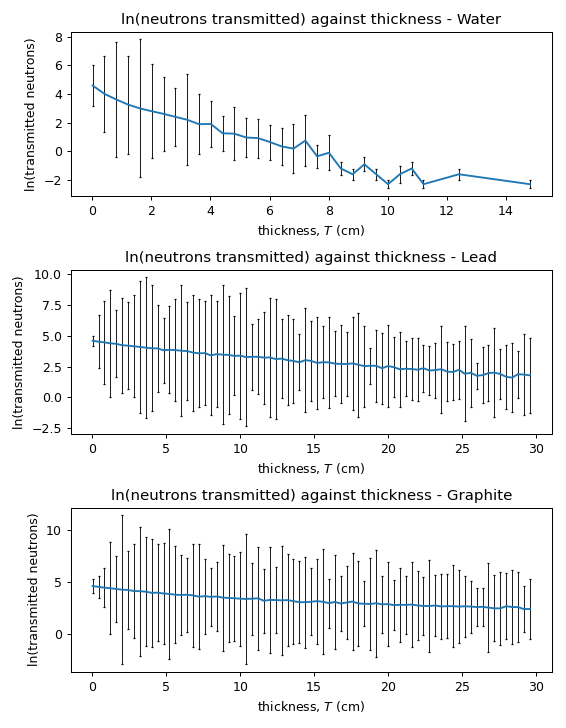

In [22]:
#clean the data so that the zero values are removed
final_water_array_transmitted_cleaned, thickness_cleaned_water, water_stdev = data_cleaner_2(water_array_transmitted, 
                                                                                    thickness, water_array_transmitted_stdev)
final_lead_array_transmitted_cleaned, thickness_cleaned_lead, lead_stdev = data_cleaner_2(lead_array_transmitted, 
                                                                                thickness, lead_array_transmitted_stdev)
final_graphite_array_transmitted_cleaned, thickness_cleaned_graphite, graphite_stdev = data_cleaner_2(
                                                        graphite_array_transmitted, thickness, graphite_array_transmitted_stdev)
#find the fitted mean free path for each material
mean_free_path_fitted_water, mean_free_path_error_water, _, _ = fit_data_1(thickness_cleaned_water, 
                                                                   final_water_array_transmitted_cleaned)
mean_free_path_fitted_lead, mean_free_path_error_lead, _, _  = fit_data_1(thickness_cleaned_lead, 
                                                                          final_lead_array_transmitted_cleaned)
mean_free_path_fitted_graphite, mean_free_path_error_graphite, _, _ = fit_data_1(thickness_cleaned_graphite, 
                                                                         final_graphite_array_transmitted_cleaned)
#print results
print('-----------------')
print('Mean Free Path Results')
print('-----------------')
print(('Fitted Total Mean Free Path For Water: ''({0:.2f} +/- {1:.2f})cm').format(mean_free_path_fitted_water, 
                                                                          mean_free_path_error_water))
print(('Fitted Total Mean Free Path For Lead: ''({0:.2f} +/- {1:.2f})cm').format(mean_free_path_fitted_lead, 
                                                                          mean_free_path_error_lead))
print(('Fitted Total Mean Free Path For Graphite: ''({0:.2f} +/- {1:.2f})cm').format(mean_free_path_fitted_graphite, 
                                                                          mean_free_path_error_graphite))
#for water
fig_1, axs_1 = plt.subplots(3, 1, figsize=(7, 9), tight_layout=True)
axs_1[0].errorbar(thickness_cleaned_water, np.log(final_water_array_transmitted_cleaned), yerr=water_stdev, ecolor='black',
                  capsize=1, elinewidth=0.7)
axs_1[0].set_title('ln(neutrons transmitted) against thickness - Water')
axs_1[0].set_xlabel('thickness, $T$ (cm)')
axs_1[0].set_ylabel('ln(transmitted neutrons)')
#for lead
axs_1[1].errorbar(thickness_cleaned_lead, np.log(final_lead_array_transmitted_cleaned), yerr=lead_stdev, ecolor='black',
                  capsize=1, elinewidth=0.7)
axs_1[1].set_title('ln(neutrons transmitted) against thickness - Lead')
axs_1[1].set_xlabel('thickness, $T$ (cm)')
axs_1[1].set_ylabel('ln(transmitted neutrons)')
#for graphite
axs_1[2].errorbar(thickness_cleaned_graphite, np.log(final_graphite_array_transmitted_cleaned), yerr=graphite_stdev,
                  ecolor='black',capsize=1, elinewidth=0.7)
axs_1[2].set_title('ln(neutrons transmitted) against thickness - Graphite')
axs_1[2].set_xlabel('thickness, $T$ (cm)')
axs_1[2].set_ylabel('ln(transmitted neutrons)')
plt.show()

A small mean free path means the neutron travels a small distance before interacting with the slabs atoms. The results above make sense as this means neutrons are likely to scatter and be absorbed more in water, due to its low mean free path. Neutrons are most likely to be transmitted by graphite due to its high mean free path. This result is in agreemeent with the printed reuslts from section 3.4. Therefore, if we were to use a material to shield against neutrons we would prefer a slab of water rather than a slab of graphite or lead. It is alsp important to note that these mean free paths are different to those found in the beggining of the report. This is because we have included the effects of absorption and scattering in these new mean free values. They are, therefore, more accurate descriptions of the mean free path in the material for neutrons.

# 3.6 Using The Woodcock Method To Simulate Neutrons Passing Through Two Slabs Of Material.

We can use the Woodcock method for this simulation, where we have a slab of graphite connected to a slab of water. This simulation is very similiar to the previous one material simulation. A problem arises when trying to implement the simulation for two materials. This is the ambiguity in mean free path. To further illustarte this point we can imagine a neutron entering the slab of material 1. At some point it will reach the boundary of material 2. If we keep on using the step size given by the mean free path of material 1, we will not get the correct step size when in material 2. This problem can be solved in two ways. First by using triginometery and second by using fictious steps. The second method is preffered as it is simpler to implement. 

First we define the majorant cross section given by:
$$\Sigma_T=max(\Sigma_1,\Sigma_2),$$ 
where $\Sigma_1$ and $\Sigma_2$ are the macroscopic cross sections in materials 1 and 2 respectively.
We then take steps according to this given by:
$$s_i = -\lambda_Tlog(u),$$
where $u$ is some randomly generated number between 0 and 1 and $\lambda_T$ is the majorant mean free path. $\lambda_T$ is the smallest mean free path out of both materials, therefore, if we are to use $s_i$ in both materials we will sometimes take steps that are too small in the region with the larger mean free path. We need to compensate for this by taking fictious steps. 

We must first check if the particle is in material 1 or 2. If the neutron is in the material with a smaller macroscopic cross section, we check if the step is fictious or real. To determine if a step is fictious or real we use:
$$v>\frac{\Sigma_1}{\Sigma_T},$$
where $v$ is some randomly generated number. If this inequality is satisfied the steps are fictious, if not then they are real. If the step is fictious the neutron does not undergo absorbtion or scattering. We just move it along a distance $s_i$ in the same direction it was previoulsy travelling in. If the step is real we check if the neutrons are absorbed or scattered just as done in the original simulation.

Finally if the neutron is in the material with a larger macroscopic cross section we always perform real steps. Now lets implement the Woodcock methdod and plot a random walk of a neutron.

<IPython.core.display.Javascript object>


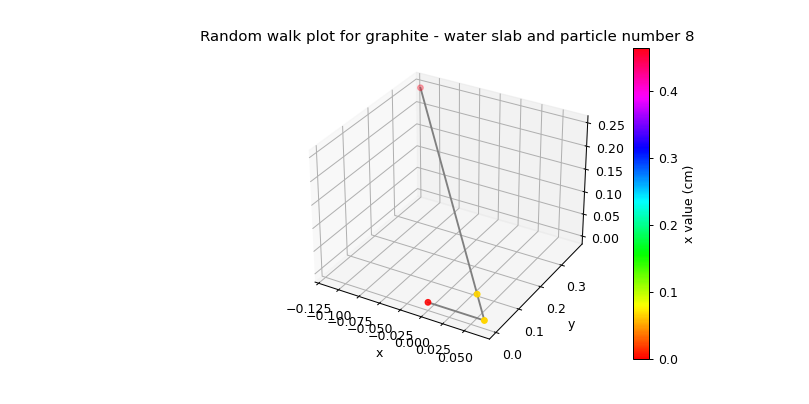

NUMBER OF TRIALS IS:  10
------------------------
Transmission For A Fixed Thickness - Graphite - Water Slab - Woodcock Simulation
------------------------
Thickness of water:  10 cm
Thickness of graphite:  10 cm
Total Neutrons:  1000
Mean Number Of Neutrons Reflected: (847.00 +/- 11.87)
Mean Number Of Neutrons Absorbed: (151.50 +/- 11.63)
Mean Number Of Neutrons Transmitted: (1.50 +/- 1.12)


In [23]:
majorant_mean_free_path = min(mean_free_path_total_graphite, mean_free_path_total_water)
number_of_particles = 1000
T_graphite = 10 #cm
T_water = 10 #cm
trial_number = 10
trajectories_woodcock = scattering_absorption_woodcock_simulation(majorant_mean_free_path, 
                                                                    macroscopic_cross_section_abs_graphite, 
                                              macroscopic_cross_section_tot_graphite, macroscopic_cross_section_abs_water, 
                                              macroscopic_cross_section_tot_water, number_of_particles, T_graphite, T_water)
particle_number = 8 #the particle whose random walk will be plotted

#plot the random walk for the combined graphite and water slab
plot_random_walk(trajectories_woodcock, particle_number, 'graphite - water slab')
#find the average values for the woodcock simulation
transmitted_mean_water_1, reflected_mean_water_1, absorbed_mean_water_1, transmitted_stdev_water_1, reflected_stdev_water_1,\
absorbed_stdev_water_1 = multiple_trials_woodcock(majorant_mean_free_path, macroscopic_cross_section_abs_graphite, 
                                              macroscopic_cross_section_tot_graphite, macroscopic_cross_section_abs_water, 
                                              macroscopic_cross_section_tot_water, number_of_particles, T_graphite, T_water, 
                                            trial_number)
#print results
print('NUMBER OF TRIALS IS: ', trial_number)
#for Woodcock simulation
print('------------------------')
print('Transmission For A Fixed Thickness - Graphite - Water Slab - Woodcock Simulation')
print('------------------------')
print('Thickness of water: ' , T_water, 'cm')
print('Thickness of graphite: ' , T_graphite, 'cm')
print('Total Neutrons: ', number_of_particles,)
print(('Mean Number Of Neutrons Reflected: ''({0:.2f} +/- {1:.2f})').format(reflected_mean_water_1, reflected_stdev_water_1))
print(('Mean Number Of Neutrons Absorbed: ''({0:.2f} +/- {1:.2f})').format(absorbed_mean_water_1, absorbed_stdev_water_1))
print(('Mean Number Of Neutrons Transmitted: ''({0:.2f} +/- {1:.2f})').format(transmitted_mean_water_1, 
                                                                              transmitted_stdev_water_1))

# Checking The Woodcock Method

We can check the woodcock method simulation by running it again, but this time setting the first material to be a vacumn. When we plot the random walk of a particle, we should expect it to move in a straight line in the vacumn. This is because the vacumn has no particles, therefore, the neutrons can not be absorbed or scattered. As the neutrons can move freely through the vacumn the $\lambda$ of the vacumn must be infinite. In turn the $\Sigma$ of the vacumn must be 0. $\lambda_T$ is the minimum $\lambda$ between the vacumn and the material, so $\lambda_T$ must be the $\lambda$ of the material not the vacumn. Finally, we can run our original simulation for 1 material and see if our reults are similiar. In order to compare the numerical results we must run the simulation multiple times as we have done before. This enbales a calculation of the mean number of neutrons transmitted, scattered and absorbed along with their errors. 

<IPython.core.display.Javascript object>


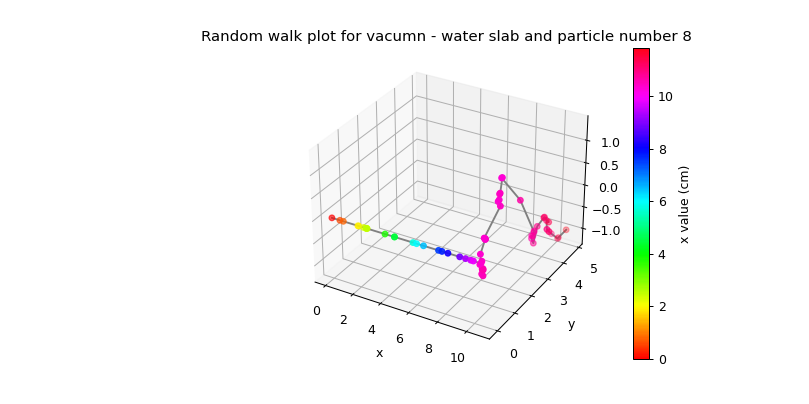

NUMBER OF TRIALS IS:  10
------------------------
Transmission For A Fixed Thickness - Vacumn - Water Slab - Woodcock Simulation
------------------------
Thickness of water:  10 cm
Thickness of vacumn:  10 cm
Total Neutrons:  1000
Mean Number Of Neutrons Reflected: (794.60 +/- 14.35)
Mean Number Of Neutrons Absorbed: (201.70 +/- 14.89)
Mean Number Of Neutrons Transmitted: (3.70 +/- 2.19)
------------------------
Transmission For A Fixed Thickness - Water - Original Simulation
------------------------
Thickness:  10 cm
Total Neutrons:  1000
Mean Number Of Neutrons Reflected: (792.20 +/- 11.76)
Mean Number Of Neutrons Absorbed: (205.20 +/- 11.51)
Mean Number Of Neutrons Transmitted: (2.60 +/- 1.36)


In [24]:
majorant_mean_free_path = mean_free_path_total_water
number_of_particles = 1000
T_vacumn = 10 #cm
T_water = 10 #cm
macroscopic_cross_section_abs_vacumn = 0
macroscopic_cross_section_tot_vacumn = 0
trial_number = 10 #number of times the simulation will be repeated
# run the woodcock simulation
trajectories_woodcock = scattering_absorption_woodcock_simulation(majorant_mean_free_path, 
                                                                    macroscopic_cross_section_abs_vacumn, 
                                              macroscopic_cross_section_tot_vacumn, macroscopic_cross_section_abs_water, 
                                              macroscopic_cross_section_tot_water, number_of_particles, T_vacumn, T_water)
particle_number = 8 #the particle whose random walk will be plotted

#plot the random walk for the combined graphite and water slab
plot_random_walk(trajectories_woodcock, particle_number, 'vacumn - water slab')
#find the average values for the woodcock simulation
transmitted_mean_water_1, reflected_mean_water_1, absorbed_mean_water_1, transmitted_stdev_water_1, reflected_stdev_water_1,\
absorbed_stdev_water_1 = multiple_trials_woodcock(majorant_mean_free_path, macroscopic_cross_section_abs_vacumn, 
                                              macroscopic_cross_section_tot_vacumn, macroscopic_cross_section_abs_water, 
                                              macroscopic_cross_section_tot_water, number_of_particles, T_vacumn, T_water, 
                                            trial_number)
#find results by using the original simulation
T = 10 #thickness of the slab of water in cm
#now find the average values for the original simulation
transmitted_mean_water_2, reflected_mean_water_2, absorbed_mean_water_2, transmitted_stdev_water_2, reflected_stdev_water_2,\
absorbed_stdev_water_2 = multiple_trials(mean_free_path_total_water, macroscopic_cross_section_abs_water, \
                                       macroscopic_cross_section_tot_water, number_of_particles, T, trial_number)

#print results
print('NUMBER OF TRIALS IS: ', trial_number)
#for Woodcock simulation
print('------------------------')
print('Transmission For A Fixed Thickness - Vacumn - Water Slab - Woodcock Simulation')
print('------------------------')
print('Thickness of water: ' , T_water, 'cm')
print('Thickness of vacumn: ' , T_vacumn, 'cm')
print('Total Neutrons: ', number_of_particles,)
print(('Mean Number Of Neutrons Reflected: ''({0:.2f} +/- {1:.2f})').format(reflected_mean_water_1, reflected_stdev_water_1))
print(('Mean Number Of Neutrons Absorbed: ''({0:.2f} +/- {1:.2f})').format(absorbed_mean_water_1, absorbed_stdev_water_1))
print(('Mean Number Of Neutrons Transmitted: ''({0:.2f} +/- {1:.2f})').format(transmitted_mean_water_1, 
                                                                              transmitted_stdev_water_1))
#for the original simulation
print('------------------------')
print('Transmission For A Fixed Thickness - Water - Original Simulation')
print('------------------------')
print('Thickness: ' , T, 'cm')
print('Total Neutrons: ', number_of_particles,)
print(('Mean Number Of Neutrons Reflected: ''({0:.2f} +/- {1:.2f})').format(reflected_mean_water_2, reflected_stdev_water_2))
print(('Mean Number Of Neutrons Absorbed: ''({0:.2f} +/- {1:.2f})').format(absorbed_mean_water_2, absorbed_stdev_water_2))
print(('Mean Number Of Neutrons Transmitted: ''({0:.2f} +/- {1:.2f})').format(transmitted_mean_water_2, 
                                                                              transmitted_stdev_water_2))

Firstly, by looking at the plot we can see that the neutron moves undisturbed for the first 10cm, which is the thickness of the vacumn. Secondly, by comparing the printed results we can see all the results agree. This accuracy would be improved for a larger number of simulations, as we only used 10 repeated simulations for our results. By taking these 2 arguments into account we can say the Woodcock method works.

# References

1. Microscopic Cross Section - an overview | ScienceDirect Topics [Internet]. Sciencedirect.com. 2021 [cited 30 April 2021]. Available from: https://www.sciencedirect.com/topics/engineering/microscopic-cross-section#:~:text=The%20microscopic%20cross%2Dsection%20%E2%80%9C%CF%83,nucleus%20(Ragheb%2C%202011)

2. Devroye L. Non- Uni form Random Variate Generation [Internet]. Eirene.de. 2021 [cited 30 April 2021]. Available from: http://www.eirene.de/Devroye.pdf